In [66]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import networkx as nx
import pandana
import keplergl
import IPython
import base64
from shapely import Point
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
import folium
import mapclassify
from scipy.stats import kendalltau, pearsonr, spearmanr, linregress, stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest, norm
import json

In [67]:
# Notebook themes
#!jt -l

In [68]:
# Notebook themes
#!jt -t chesterish
#!jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd  -kl -T -N
#!jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

#### Importing the network

In [69]:
# Define the bounding box coordinates (south, north, west, east)
bbox = (-33.646126, -33.296186, -70.817511, -70.492755)
# Create a graph from the bounding box using the bbox parameter
G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)

C:\Users\mario\AppData\Local\Temp\ipykernel_17696\3383322036.py:4: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)


In [70]:
# Get the geometry of the city polygon
city_total_polygon = ox.geocode_to_gdf("Región metropolitana de Santiago")['geometry'].iloc[0]

# Create a polygon from the bounding box
min_lat, max_lat, min_lon, max_lon = bbox
sub_polygon_coords = [
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
]
sub_polygon = Polygon(sub_polygon_coords)

# Ensure the sub-polygon is within the city polygon
if sub_polygon.within(city_total_polygon):
    print("Sub-polygon is within the city polygon.")
else:
    print("Sub-polygon is not within the city polygon.")

# Create GeoDataFrames for plotting
city_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[city_total_polygon])
sub_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[sub_polygon])
city_polygon = sub_gdf['geometry'].iloc[0]

Sub-polygon is within the city polygon.


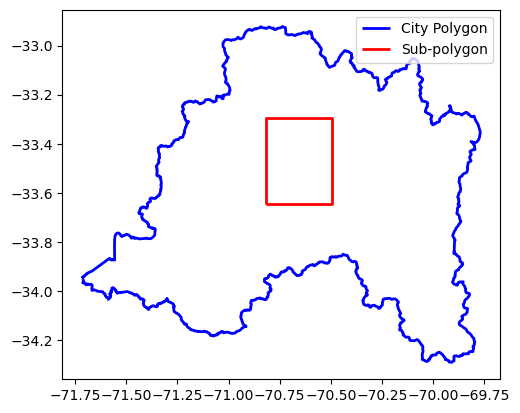

In [71]:
# Plot the city polygon and the sub-polygon
fig, ax = plt.subplots()
city_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='City Polygon')
sub_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label='Sub-polygon')
plt.legend()
plt.show()

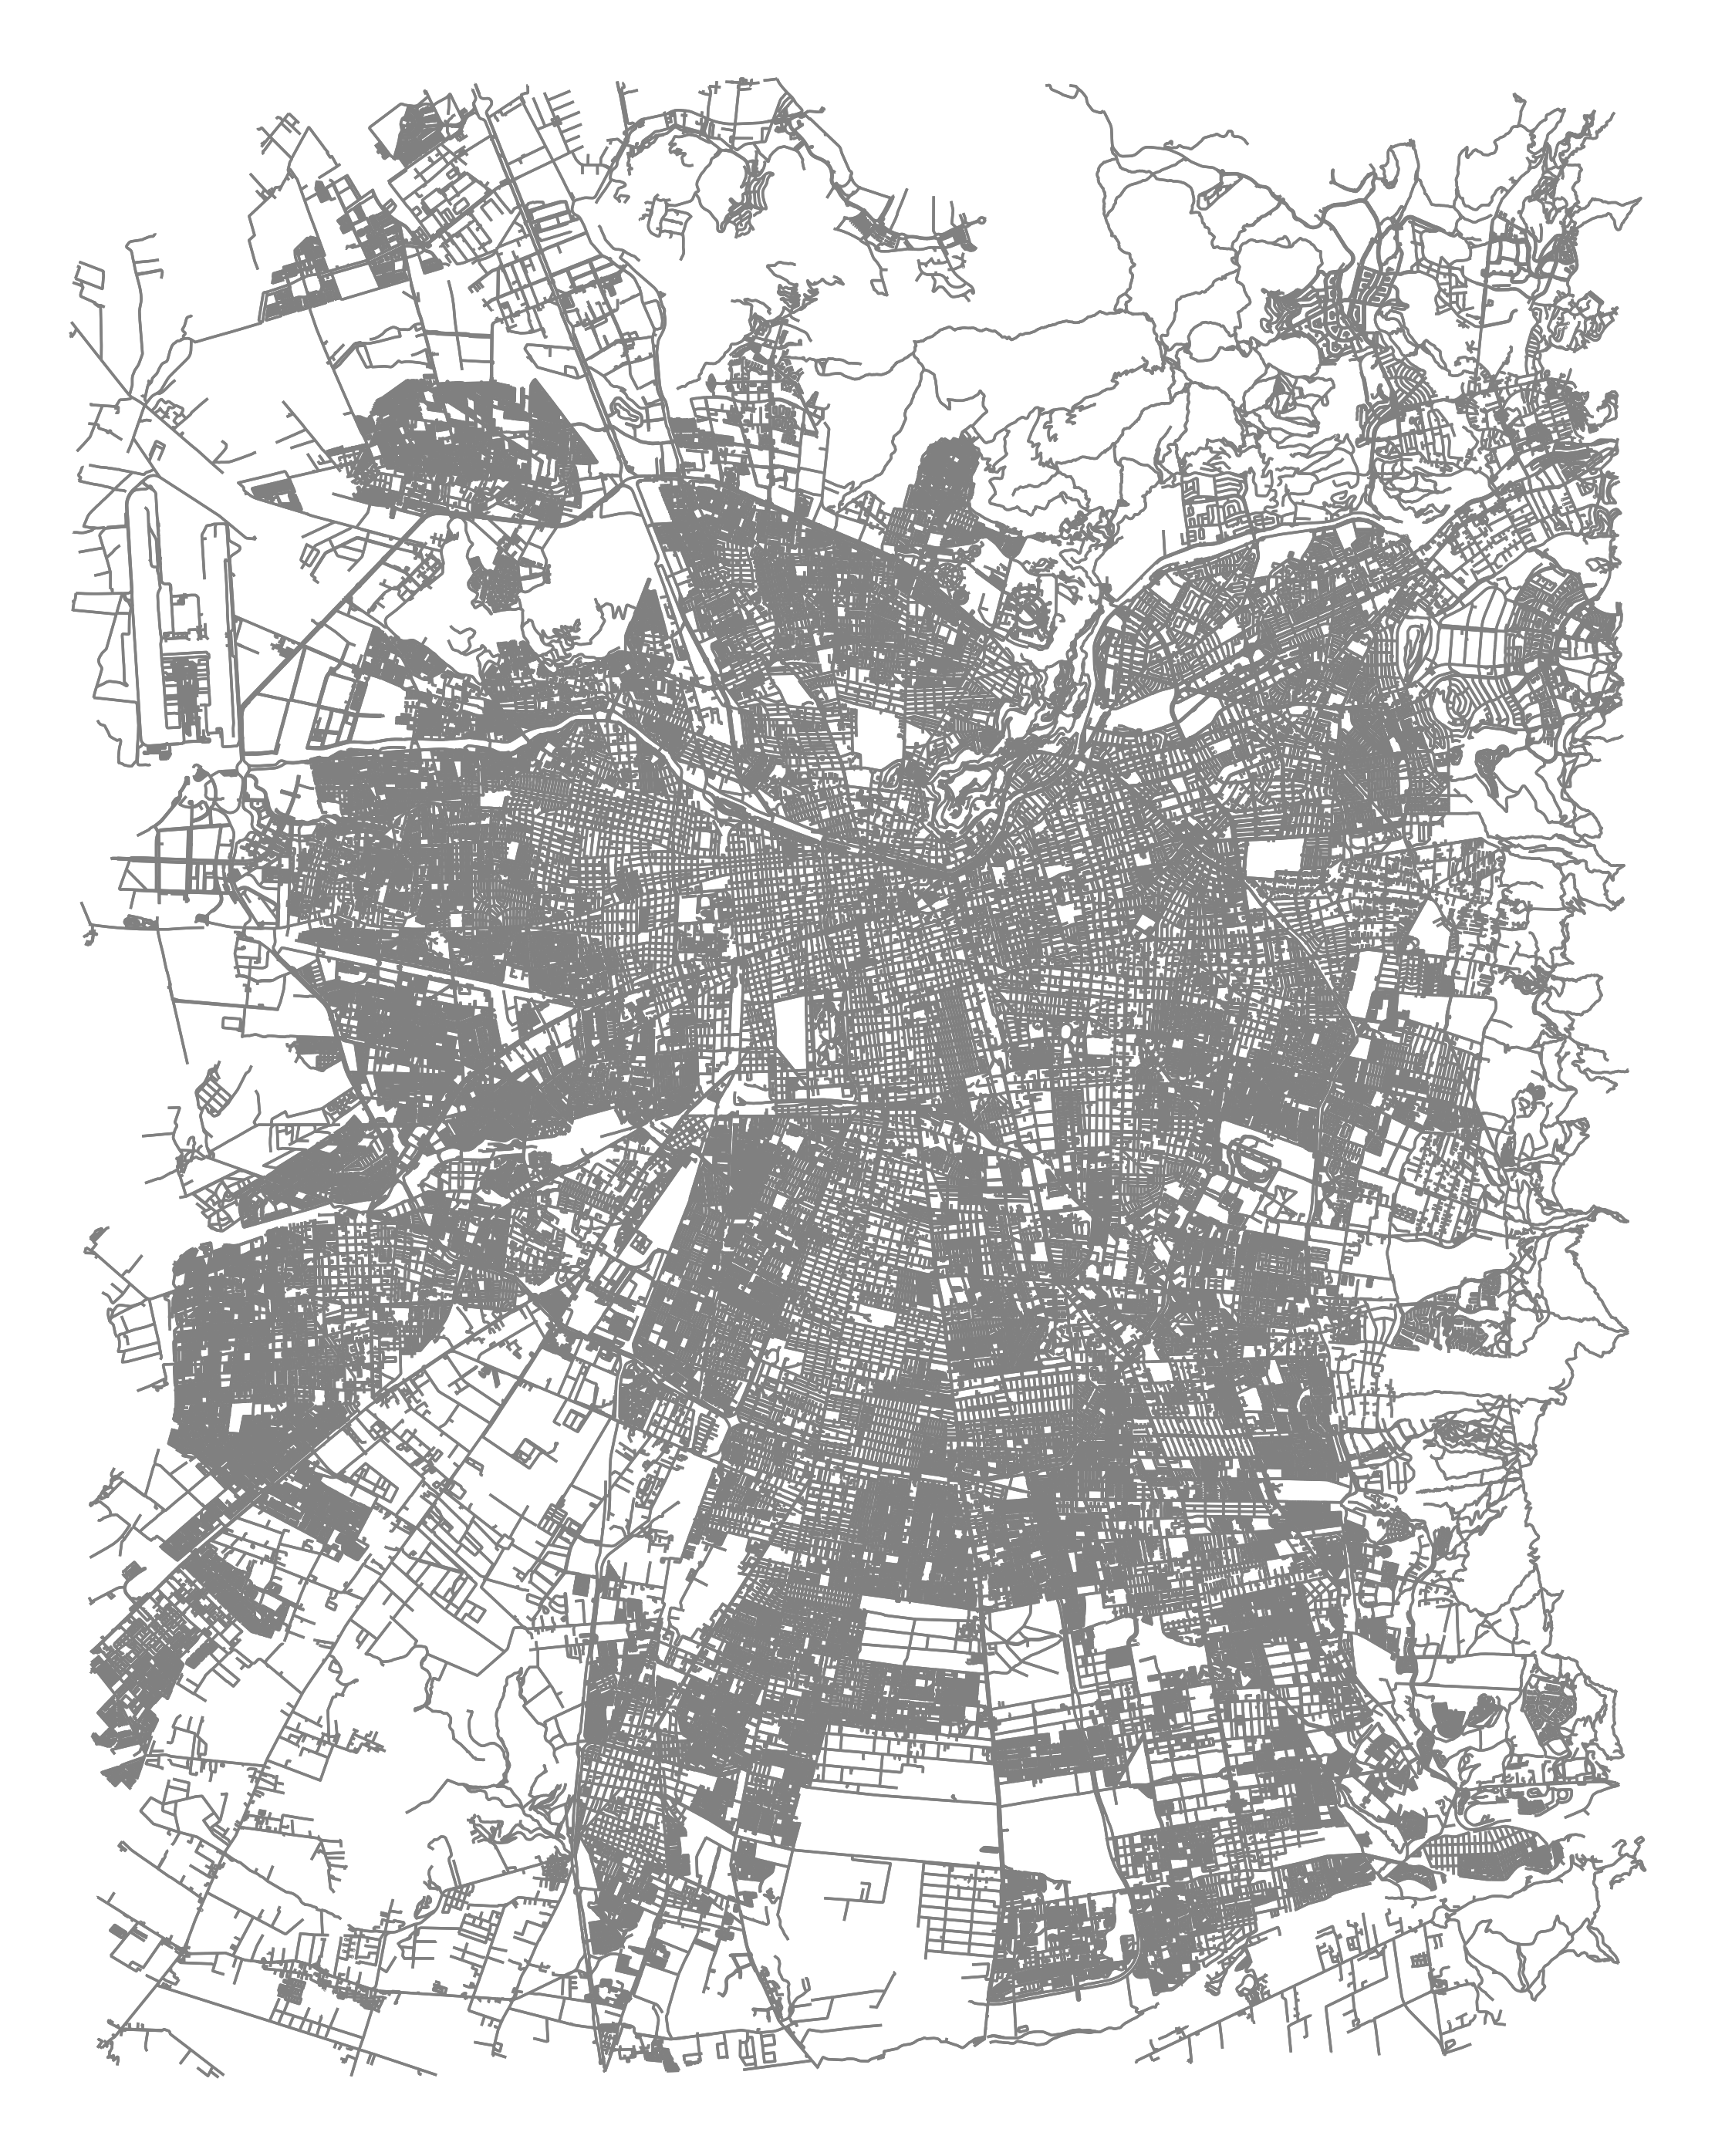

In [72]:
mpl.rcParams['figure.dpi'] = 500
#fig, ax = ox.plot_graph(ox.project_graph(G), node_color='#4CFFD6', node_size=0.5,
#                       edge_color='#4CFFD6', edge_linewidth=0.1, 
#                       figsize=(7, 7))

fig, ax = ox.plot_graph(ox.project_graph(G), 
                       figsize=(7, 7), node_size = 0, bgcolor="white", node_color = "black", 
                       edge_color='gray', edge_linewidth=0.5)

In [73]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges= True)

In [74]:
nodes.head(3)

y          x          highway  street_count  ref  \
osmid                                                              
386138 -33.442901 -70.646254  traffic_signals             4  NaN   
386139 -33.443129 -70.647249              NaN             3  NaN   
386140 -33.443035 -70.647670  traffic_signals             4  NaN   

                           geometry  
osmid                                
386138  POINT (-70.64625 -33.44290)  
386139  POINT (-70.64725 -33.44313)  
386140  POINT (-70.64767 -33.44304)

In [75]:
edges.head(3)

osmid  oneway lanes  \
u      v           key                            
386138 14805063    0    121815664   False     3   
       10685413095 0    121815695   False     4   
       10723403828 0    679088092   False     3   

                                                         name    highway  \
u      v           key                                                     
386138 14805063    0                         Enrique Mac Iver  secondary   
       10685413095 0    Avenida Libertador Bernardo O'Higgins    primary   
       10723403828 0                       Avenida Santa Rosa  secondary   

                       maxspeed reversed  length  \
u      v           key                             
386138 14805063    0         50    False  18.225   
       10685413095 0         50    False  11.518   
       10723403828 0         50     True  13.388   

                                                                 geometry  \
u      v           key                                                      
386138 14805063    0    LINESTRING (-70.64625 -33.44290, -70.64630 -33...   
       10685413095 0    LINESTRING (-70.64625 -33.44290, -70.64613 -33...   
       10723403828 0    LINESTRING (-70.64625 -33.44290, -70.64622 -33...   

                       bridge access width  ref junction service tunnel area  
u      v           key                                                        
386138 14805063    0      NaN    NaN   NaN  NaN      NaN     NaN    NaN  NaN  
       10685413095 0      NaN    NaN   NaN  NaN      NaN     NaN    NaN  NaN  
       10723403828 0      NaN    NaN   NaN  NaN      NaN     NaN    NaN  NaN

##### Creating Pandana Graph for shortest path calculation

In [76]:
# FOR PANDANA
edges_pdna = edges.droplevel(level=2)
edges_pdna["from"] = edges_pdna.index.get_level_values("u")
edges_pdna["to"] = edges_pdna.index.get_level_values("v")
edges_pdna = edges_pdna.drop(['osmid', 'highway', "oneway", "reversed",
                "lanes", "name", "geometry", "maxspeed",
                "access", "junction", "width", "bridge",
                "tunnel", "service", "ref", "area"], axis=1)
edges_pdna.insert(2, "length", edges_pdna.pop("length"))

In [77]:
edges_pdna

from           to  length
u           v                                            
386138      14805063          386138     14805063  18.225
            10685413095       386138  10685413095  11.518
            10723403828       386138  10723403828  13.388
            10723406208       386138  10723406208  10.632
386139      10723406208       386139  10723406208  85.110
...                              ...          ...     ...
12087382933 5882603220   12087382933   5882603220  22.364
12087382934 5882603228   12087382934   5882603228  26.491
12088014984 7466690501   12088014984   7466690501  68.326
12088014985 5788266377   12088014985   5788266377  65.649
12088014986 5788266355   12088014986   5788266355  65.644

[578568 rows x 3 columns]

In [78]:
nodes_pdna = nodes[["x", "y"]]

In [79]:
G_pdna = pandana.Network(nodes_pdna['x'], nodes_pdna['y'], 
                          edges_pdna['from'], edges_pdna['to'], 
                          edges_pdna[['length']], twoway = True)

#### Defining X minutes city

In [80]:
X_minutes = 15

#### Defining hotels (source nodes)

In [81]:
# Importing the complete hotel dataset

hotels_total = pd.read_excel("Santiago_listings_airbnb.xlsx", sheet_name = "listings_cleaned2")

hotels_total = hotels_total.rename(columns={'longitude': 'x_H', 'latitude': 'y_H', 
                                           "number_of_reviews": "review_count_H", "review_scores_rating": "score_H"})

hotels_total['amenities_count'] = hotels_total['amenities'].apply(lambda x: len(json.loads(x)))
hotels_total["name_H"] = range(1, len(hotels_total)+1)

In [82]:
hotels_total

id  host_response_time  host_response_rate  \
0                   52811                 NaN                 NaN   
1                   53494      within an hour                1.00   
2                   88944  within a few hours                1.00   
3                   90694      within an hour                0.90   
4                   90769      within an hour                0.90   
...                   ...                 ...                 ...   
7885  1182168572299467639      within an hour                1.00   
7886  1182537073411262441      within an hour                0.99   
7887  1182561676551721364      within an hour                1.00   
7888  1183358258852125407                 NaN                 NaN   
7889  1184043971058046693      within an hour                1.00   

      host_acceptance_rate host_is_superhost neighbourhood_cleansed  \
0                      NaN                 f            Providencia   
1                     0.74                 f           Lo Barnechea   
2                     1.00                 t            Providencia   
3                     0.82                 t            Providencia   
4                     0.82                 t            Providencia   
...                    ...               ...                    ...   
7885                  0.99                 t       Estación Central   
7886                  1.00                 t               Santiago   
7887                  0.61                 f               Santiago   
7888                  0.80                 f               Santiago   
7889                  0.75                 f             La Florida   

            y_H        x_H       property_type        room_type  ...  \
0    -33.429590 -70.618800  Entire rental unit  Entire home/apt  ...   
1    -33.345210 -70.295430  Entire rental unit  Entire home/apt  ...   
2    -33.421410 -70.608320        Entire condo  Entire home/apt  ...   
3    -33.426290 -70.618660  Entire rental unit  Entire home/apt  ...   
4    -33.428640 -70.621780  Entire rental unit  Entire home/apt  ...   
...         ...        ...                 ...              ...  ...   
7885 -33.453342 -70.691359  Entire rental unit  Entire home/apt  ...   
7886 -33.447215 -70.644868  Entire rental unit  Entire home/apt  ...   
7887 -33.443328 -70.644818  Entire rental unit  Entire home/apt  ...   
7888 -33.436913 -70.670426  Entire rental unit  Entire home/apt  ...   
7889 -33.535151 -70.591978  Entire rental unit  Entire home/apt  ...   

      review_count_H  score_H  review_scores_accuracy  \
0                 45     4.42                    4.59   
1                 41     4.76                    4.80   
2                212     4.72                    4.77   
3                 72     4.72                    4.76   
4                 11     5.00                    5.00   
...              ...      ...                     ...   
7885               2     5.00                    5.00   
7886               1     5.00                    5.00   
7887               2     5.00                    5.00   
7888               1     5.00                    5.00   
7889               1     5.00                    5.00   

      review_scores_cleanliness review_scores_checkin  \
0                          4.52                  4.66   
1                          4.90                  4.88   
2                          4.61                  4.90   
3                          4.77                  4.77   
4                          5.00                  5.00   
...                         ...                   ...   
7885                       5.00                  5.00   
7886                       5.00                  5.00   
7887                       5.00                  5.00   
7888                       5.00                  5.00   
7889                       5.00                  5.00   

      review_scores_communication  review_scores_location  \
0                            4.59            

In [83]:
# Classifying amenities

# Step-by-step flattening process
flattened_list = []
for json_str in hotels_total['amenities']:
    sentences = json.loads(json_str)  # Parse the JSON string
    flattened_list.extend(sentences)

# Find the unique sentences
unique_sentences = set(flattened_list)

# Convert the set to a list if needed
amenities_unique_sentences_list = list(unique_sentences)

#pd.DataFrame(amenities_unique_sentences_list).to_csv('amenities_unique_sentences_list.csv', index=False)

In [84]:
# Define categories

# Add the 'TVs' category
hotels_total['TVs'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword in json.loads(amenities) for keyword in ['TV', 'HDTV']) else 0
)

# Add the 'WiFi' category
hotels_total['Wifi'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['Wifi', 'Wi-Fi', 'internet']) else 0
)

# Add the 'Parking' category
hotels_total['Parking'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['parking', 'garage']) else 0
)

# Add the 'Kitchen Appliances' category
hotels_total['Kitchen_Appliances'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['oven', 'stove', 'kitchen', 'coffee maker', 'refrigerator', 'microwave', 'toaster']) else 0
)

# Add the 'Bathroom Amenities' category
hotels_total['Bathroom_Amenities'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['shampoo', 'conditioner', 'soap', 'towels', 'bathroom']) else 0
)

# Add the 'Child Amenities' category
hotels_total['Child_Amenities'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['children', 'child', 'crib', 'high chair', 'playground']) else 0
)

# Add the 'Entertainment Systems' category
hotels_total['Entertainment_Systems'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['sound system', 'ping pong', 'game console', 'DVD player']) else 0
)

# Add the 'Miscellaneous' category
hotels_total['Miscellaneous'] = hotels_total.apply(
    lambda row: 1 if not any(row[category] for category in ['TVs', 'Wifi', 'Parking', 'Kitchen_Appliances', 'Bathroom_Amenities', 'Child_Amenities', 'Entertainment_Systems']) else 0,
    axis=1
)

In [85]:
hotels_total.head(3)

id  host_response_time  host_response_rate  host_acceptance_rate  \
0  52811                 NaN                 NaN                   NaN   
1  53494      within an hour                 1.0                  0.74   
2  88944  within a few hours                 1.0                  1.00   

  host_is_superhost neighbourhood_cleansed       y_H       x_H  \
0                 f            Providencia -33.42959 -70.61880   
1                 f           Lo Barnechea -33.34521 -70.29543   
2                 t            Providencia -33.42141 -70.60832   

        property_type        room_type  ...  amenities_count  name_H  TVs  \
0  Entire rental unit  Entire home/apt  ...               30       1    0   
1  Entire rental unit  Entire home/apt  ...                8       2    0   
2        Entire condo  Entire home/apt  ...               24       3    0   

   Wifi Parking  Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0     1       1                   1                   1                0   
1     0       1                   1                   0                0   
2     1       1                   1                   1                0   

   Entertainment_Systems  Miscellaneous  
0                      0              0  
1                      0              0  
2                      0              0  

[3 rows x 37 columns]

In [86]:
# Filtering accommodation by presence inside bbox
hotels_df = hotels_total.copy()
print("Total number of accomodation in city: ", len(hotels_df))

hotels_df['in_bbox'] = hotels_df.apply(lambda x: city_polygon.contains(Point(x.x_H, x.y_H)), axis=1)

hotels_df = hotels_df.loc[(hotels_df.in_bbox == True)].reset_index(drop=True)
hotels_df.drop("in_bbox", axis=1, inplace=True)
print("Number of hotels: ", len(hotels_df))
hotels_df.head(3)

Total number of accomodation in city:  7890
Number of hotels:  7462


id  host_response_time  host_response_rate  host_acceptance_rate  \
0  52811                 NaN                 NaN                   NaN   
1  88944  within a few hours                 1.0                  1.00   
2  90694      within an hour                 0.9                  0.82   

  host_is_superhost neighbourhood_cleansed       y_H       x_H  \
0                 f            Providencia -33.42959 -70.61880   
1                 t            Providencia -33.42141 -70.60832   
2                 t            Providencia -33.42629 -70.61866   

        property_type        room_type  ...  amenities_count  name_H  TVs  \
0  Entire rental unit  Entire home/apt  ...               30       1    0   
1        Entire condo  Entire home/apt  ...               24       3    0   
2  Entire rental unit  Entire home/apt  ...               18       4    0   

   Wifi Parking  Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0     1       1                   1                   1                0   
1     1       1                   1                   1                0   
2     0       0                   1                   1                0   

   Entertainment_Systems  Miscellaneous  
0                      0              0  
1                      0              0  
2                      0              0  

[3 rows x 37 columns]

In [87]:
# Getting the nearest node ids to each hotel

id_nearest_node_H, dist_H = ox.distance.nearest_nodes(G, hotels_df['x_H'], 
                                              hotels_df['y_H'], 
                                              return_dist=True)

print("Successful mapping: ", len(hotels_df) == len(id_nearest_node_H))


hotels_df.insert(7, "id_nearest_node_H", id_nearest_node_H)
hotels_df.insert(8, "x_nearest_node_H", 
                 np.float64(nodes.x[id_nearest_node_H]))
hotels_df.insert(9, "y_nearest_node_H", 
                 np.float64(nodes.y[id_nearest_node_H]))

hotels_df.head(3)

C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Successful mapping:  True


id  host_response_time  host_response_rate  host_acceptance_rate  \
0  52811                 NaN                 NaN                   NaN   
1  88944  within a few hours                 1.0                  1.00   
2  90694      within an hour                 0.9                  0.82   

  host_is_superhost neighbourhood_cleansed       y_H  id_nearest_node_H  \
0                 f            Providencia -33.42959           59712736   
1                 t            Providencia -33.42141          448786614   
2                 t            Providencia -33.42629          224544255   

   x_nearest_node_H  y_nearest_node_H  ...  amenities_count name_H TVs  Wifi  \
0        -70.619021        -33.429250  ...               30      1   0     1   
1        -70.608301        -33.421874  ...               24      3   0     1   
2        -70.618849        -33.426041  ...               18      4   0     0   

   Parking  Kitchen_Appliances  Bathroom_Amenities Child_Amenities  \
0        1                   1                   1               0   
1        1                   1                   1               0   
2        0                   1                   1               0   

   Entertainment_Systems  Miscellaneous  
0                      0              0  
1                      0              0  
2                      0              0  

[3 rows x 40 columns]

Text(0, 0.5, 'review score')

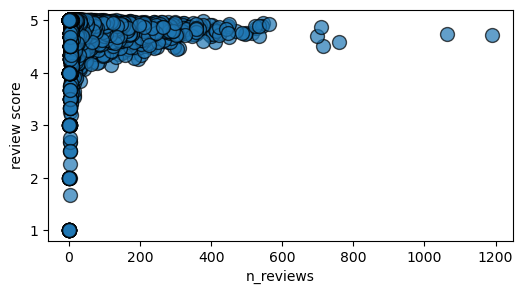

In [88]:
# Distribution of reviews as a function of number of reviews
# for the hotels
mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(hotels_df["review_count_H"], hotels_df["score_H"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [89]:
# Calculating Bayesian Average
#m = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
#C = 250
#hotels_df["Bayesian_avg_H"] = ((hotels_df.score_H * hotels_df.review_count_H) 
#                                  + (C * m)) / (C + hotels_df.review_count_H)

S = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
m_avg = np.mean(hotels_df.review_count_H[hotels_df["score_H"] > 0])

hotels_df["Bayesian_avg_H"] = (hotels_df.review_count_H/(hotels_df.review_count_H + m_avg)) * hotels_df.score_H +\
                                (m_avg/(hotels_df.review_count_H + m_avg)) * S
hotels_df = hotels_df[(hotels_df.score_H > 0) & (hotels_df.review_count_H > 0)]
print("Number of accommodations: ", len(hotels_df))
hotels_df.head(3)

Number of accommodations:  7462


id  host_response_time  host_response_rate  host_acceptance_rate  \
0  52811                 NaN                 NaN                   NaN   
1  88944  within a few hours                 1.0                  1.00   
2  90694      within an hour                 0.9                  0.82   

  host_is_superhost neighbourhood_cleansed       y_H  id_nearest_node_H  \
0                 f            Providencia -33.42959           59712736   
1                 t            Providencia -33.42141          448786614   
2                 t            Providencia -33.42629          224544255   

   x_nearest_node_H  y_nearest_node_H  ...  name_H TVs Wifi  Parking  \
0        -70.619021        -33.429250  ...       1   0    1        1   
1        -70.608301        -33.421874  ...       3   0    1        1   
2        -70.618849        -33.426041  ...       4   0    0        0   

   Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0                   1                   1                0   
1                   1                   1                0   
2                   1                   1                0   

  Entertainment_Systems  Miscellaneous  Bayesian_avg_H  
0                     0              0        4.580945  
1                     0              0        4.724513  
2                     0              0        4.729970  

[3 rows x 41 columns]

<Axes: xlabel='Accommodation type', ylabel='Count'>

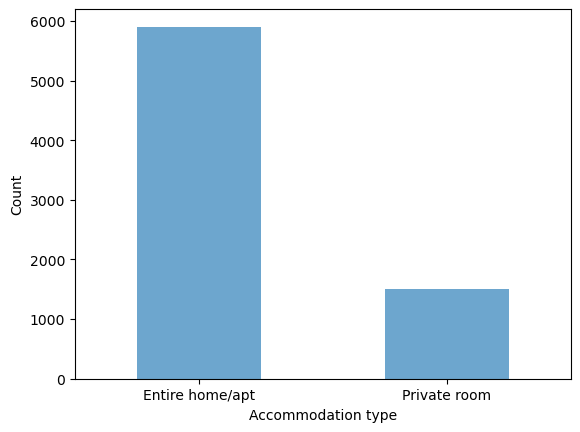

In [90]:
pd.DataFrame(hotels_df[(hotels_df.room_type == "Entire home/apt") | (hotels_df.room_type == "Private room")].room_type.sort_values().value_counts(sort=True)).plot.bar(alpha=0.65, xlabel="Accommodation type", ylabel="Count", rot=0, legend=False)

#### Defining attractions (destination nodes)

In [91]:
# Importing the complete attractions dataset
attractions_col_names = ["gcode_A", "dcode_A", "name_A", "score_A", "review_count_A", 
                         "x_A", "y_A", "istat_pro_com_A", "municipality_A"] 

attractions_total = pd.read_excel("attraction_dataset_Santiago.xlsx", sheet_name = "attraction_dataset_filtered", 
                                  names = attractions_col_names)

attractions_total.head(3)

gcode_A   dcode_A               name_A  score_A  review_count_A        x_A  \
0  g294305   d314481  Cerro San Cristobal      4.5           18592 -70.631378   
1  g294305   d314522    Cerro Santa Lucia      4.5           19734 -70.631378   
2  g294305  d8594663        Sky Costanera      4.5           15382 -70.606728   

         y_A  istat_pro_com_A municipality_A  
0 -33.420242                0       Santiago  
1 -33.420242                0       Santiago  
2 -33.416744                0       Santiago

In [92]:
# Filtering attractions by municipality and presence inside bbox
attractions_df = attractions_total.copy()
attractions_df['in_bbox'] = attractions_df.apply(lambda x: city_polygon.contains(Point(x.x_A, x.y_A)), axis=1)
attractions_df = attractions_df.loc[(attractions_df.municipality_A == "Santiago") &
                                   (attractions_df.in_bbox == True)].reset_index(drop=True)
attractions_df.drop("in_bbox", axis=1, inplace=True)
print("Number of attractions: ", len(attractions_df))
attractions_df.head(3)

Number of attractions:  901


gcode_A   dcode_A               name_A  score_A  review_count_A        x_A  \
0  g294305   d314481  Cerro San Cristobal      4.5           18592 -70.631378   
1  g294305   d314522    Cerro Santa Lucia      4.5           19734 -70.631378   
2  g294305  d8594663        Sky Costanera      4.5           15382 -70.606728   

         y_A  istat_pro_com_A municipality_A  
0 -33.420242                0       Santiago  
1 -33.420242                0       Santiago  
2 -33.416744                0       Santiago

Text(0, 0.5, 'review score')

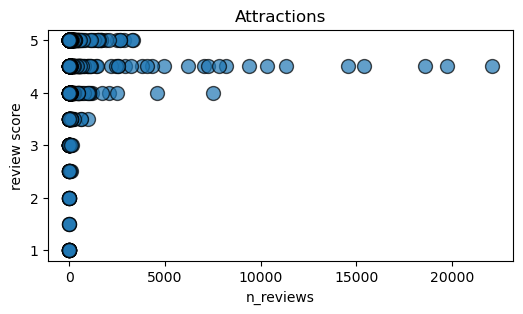

In [93]:
# Distribution of reviews as a function of number of reviews
# for the attractions
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(attractions_df["review_count_A"], attractions_df["score_A"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Attractions")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

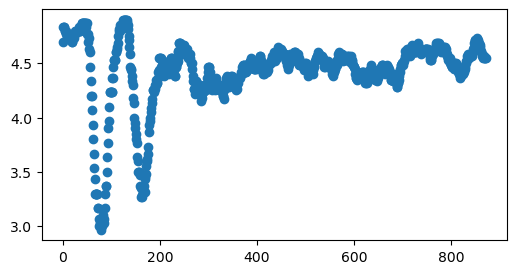

In [94]:
window = 30
j = window - 1
moving_avg = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_avg.append(np.mean(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_avg)    
#ax.set(ylim=(0, 0.000025))

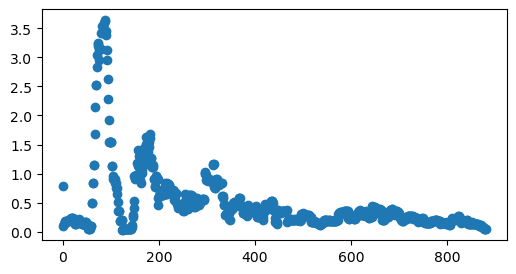

In [95]:
window = 20
j = window - 1
moving_var = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_var.append(np.var(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_var)    
#ax.set(ylim=(0, 0.000025))

In [96]:
# Calculating Bayesian Average for attractions
#m = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
#C = 100
#attractions_df["Bayesian_avg_A"] = ((attractions_df.score_A * attractions_df.review_count_A) 
#                                  + (C * m)) / (C + attractions_df.review_count_A)

S = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
m_avg = np.mean(attractions_df.review_count_A[attractions_df["score_A"] > 0])

attractions_df["Bayesian_avg_A"] = (attractions_df.review_count_A/(attractions_df.review_count_A + m_avg)) * attractions_df.score_A +\
                                (m_avg/(attractions_df.review_count_A + m_avg)) * S
attractions_df = attractions_df[(attractions_df.score_A > 0) & (attractions_df.review_count_A > 0)]
print("Number of attractions: ", len(attractions_df))
attractions_df.head(10)

Number of attractions:  901


gcode_A   dcode_A                                           name_A  \
0  g294305   d314481                              Cerro San Cristobal   
1  g294305   d314522                                Cerro Santa Lucia   
2  g294305  d8594663                                    Sky Costanera   
3  g294305  d2212241                               Viña Cousino Macul   
4  g294305   d640283                                 Barrio Lastarria   
5  g294305   d314525                           Casa Museo La Chascona   
6  g294305  d3228943                                 Costanera Center   
7  g294305   d314523                                       Bellavista   
8  g294305  d1886318                Museum of Memory and Human Rights   
9  g294305   d314520  Metropolitan Cathedral (Catedral Metropolitana)   

   score_A  review_count_A        x_A        y_A  istat_pro_com_A  \
0      4.5           18592 -70.631378 -33.420242                0   
1      4.5           19734 -70.631378 -33.420242                0   
2      4.5           15382 -70.606728 -33.416744                0   
3      5.0            2882 -70.560593 -33.497417                0   
4      4.5            8166 -70.641151 -33.438850                0   
5      4.5            9408 -70.634422 -33.431122                0   
6      4.5           14561 -70.607239 -33.417355                0   
7      4.5            7028 -70.632767 -33.434010                0   
8      4.5            6182 -70.679436 -33.439903                0   
9      4.5           10358 -70.651413 -33.437611                0   

  municipality_A  Bayesian_avg_A  
0       Santiago        4.498641  
1       Santiago        4.498719  
2       Santiago        4.498364  
3       Santiago        4.937336  
4       Santiago        4.496979  
5       Santiago        4.497363  
6       Santiago        4.498274  
7       Santiago        4.496513  
8       Santiago        4.496062  
9       Santiago        4.497597

In [97]:
# Getting the nearest node ids to each attraction

id_nearest_node_A, dist_A = ox.distance.nearest_nodes(G, attractions_df['x_A'], 
                                              attractions_df['y_A'], 
                                              return_dist=True)

print("Successful mapping: ", len(attractions_df) == len(id_nearest_node_A))


attractions_df.insert(7, "id_nearest_node_A", id_nearest_node_A)
attractions_df.insert(8, "x_nearest_node_A", 
                 np.float64(nodes.x[id_nearest_node_A]))
attractions_df.insert(9, "y_nearest_node_A", 
                 np.float64(nodes.y[id_nearest_node_A]))

attractions_df.head(3)

Successful mapping:  True


C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


gcode_A   dcode_A               name_A  score_A  review_count_A        x_A  \
0  g294305   d314481  Cerro San Cristobal      4.5           18592 -70.631378   
1  g294305   d314522    Cerro Santa Lucia      4.5           19734 -70.631378   
2  g294305  d8594663        Sky Costanera      4.5           15382 -70.606728   

         y_A  id_nearest_node_A  x_nearest_node_A  y_nearest_node_A  \
0 -33.420242         2956545712        -70.630902        -33.421310   
1 -33.420242         2956545712        -70.630902        -33.421310   
2 -33.416744        10027535342        -70.606979        -33.416643   

   istat_pro_com_A municipality_A  Bayesian_avg_A  
0                0       Santiago        4.498641  
1                0       Santiago        4.498719  
2                0       Santiago        4.498364

In [98]:
# Filtering top-k attractions based on Bayesian avg.
k = len(attractions_df[attractions_df.Bayesian_avg_A >= 4]) #150 #   len(attractions_df)
top_k_A_df = attractions_df.sort_values('Bayesian_avg_A', ascending = False)[0:k]
top_k_A_df.reset_index(drop = True, inplace=True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

top_k_A_df[["name_A", "score_A", "review_count_A", "Bayesian_avg_A"]].head(10)

name_A  score_A  review_count_A  Bayesian_avg_A
0  Free Walking Tour of Santiago      5.0            3305        4.944580
1                   Stamp's Tour      5.0            3295        4.944428
2             Viña Cousino Macul      5.0            2882        4.937336
3   Morande Turismo & Transporte      5.0            2655        4.932609
4                    Sousas Tour      5.0            2642        4.932317
5                   Tours 4 Tips      5.0            2506        4.929098
6                     Smart Tour      5.0            2078        4.916621
7             La Bicicleta Verde      5.0            1943        4.911721
8                    ViajarChile      5.0            1673        4.899962
9                      Full Tour      5.0            1662        4.899416

In [99]:
len(top_k_A_df)

898

#### Defining restaurants (destination nodes)

In [100]:
# Importing the complete restaurants dataset
restaurants_col_names = ["gcode_A", "dcode_A", "name_R", "score_R", "review_count_R", 
                         "x_R", "y_R", "istat_pro_com_R", "municipality_R"] 

restaurants_total = pd.read_excel("restaurant_dataset_Santiago.xlsx", sheet_name = "restaurant_dataset_filtered", 
                                  names = restaurants_col_names)

restaurants_total.head(3)

gcode_A    dcode_A                                          name_R  \
0  g294305   d1782826  Restaurant La Tabla de Borde Río | Steak House   
1  g294305  d26347570                         OTAKI Nikkei&SteakHouse   
2  g294305  d15184025                               KrossBar BordeRío   

   score_R  review_count_R        x_R        y_R  istat_pro_com_R  \
0      4.0             310 -70.579178 -33.381668                0   
1      5.0             511 -70.592087 -33.402180                0   
2      5.0            2081 -70.579933 -33.381901                0   

  municipality_R  
0       Santiago  
1       Santiago  
2       Santiago

In [101]:
# Filtering restaurants by municipality
restaurants_df = restaurants_total.copy()
restaurants_df['in_bbox'] = restaurants_df.apply(lambda x: city_polygon.contains(Point(x.x_R, x.y_R)), axis=1)
restaurants_df = restaurants_df.loc[(restaurants_df.municipality_R == "Santiago") &
                                   (restaurants_df.in_bbox == True)].reset_index(drop=True)
restaurants_df.drop("in_bbox", axis=1, inplace=True)
restaurants_df.head(3)

gcode_A    dcode_A                                          name_R  \
0  g294305   d1782826  Restaurant La Tabla de Borde Río | Steak House   
1  g294305  d26347570                         OTAKI Nikkei&SteakHouse   
2  g294305  d15184025                               KrossBar BordeRío   

   score_R  review_count_R        x_R        y_R  istat_pro_com_R  \
0      4.0             310 -70.579178 -33.381668                0   
1      5.0             511 -70.592087 -33.402180                0   
2      5.0            2081 -70.579933 -33.381901                0   

  municipality_R  
0       Santiago  
1       Santiago  
2       Santiago

Text(0, 0.5, 'review score')

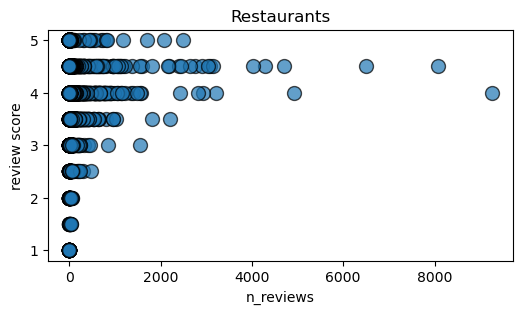

In [102]:
# Distribution of reviews as a function of number of reviews
# for the restaurants
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(restaurants_df["review_count_R"], restaurants_df["score_R"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Restaurants")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [103]:
# Calculating Bayesian Average for restaurants
#m = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
#C = 100
#restaurants_df["Bayesian_avg_R"] = ((restaurants_df.score_R * restaurants_df.review_count_R) 
#                                  + (C * m)) / (C + restaurants_df.review_count_R)

S = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
m_avg = np.mean(restaurants_df.review_count_R[restaurants_df["score_R"] > 0])

restaurants_df["Bayesian_avg_R"] = (restaurants_df.review_count_R/(restaurants_df.review_count_R + m_avg)) * restaurants_df.score_R +\
                                (m_avg/(restaurants_df.review_count_R + m_avg)) * S
restaurants_df = restaurants_df[(restaurants_df.score_R > 0) & (restaurants_df.review_count_R > 0)]
print("Number of restaurants: ", len(restaurants_df))
restaurants_df.head(3)

Number of restaurants:  3111


gcode_A    dcode_A                                          name_R  \
0  g294305   d1782826  Restaurant La Tabla de Borde Río | Steak House   
1  g294305  d26347570                         OTAKI Nikkei&SteakHouse   
2  g294305  d15184025                               KrossBar BordeRío   

   score_R  review_count_R        x_R        y_R  istat_pro_com_R  \
0      4.0             310 -70.579178 -33.381668                0   
1      5.0             511 -70.592087 -33.402180                0   
2      5.0            2081 -70.579933 -33.381901                0   

  municipality_R  Bayesian_avg_R  
0       Santiago        3.966040  
1       Santiago        4.806407  
2       Santiago        4.945435

In [104]:
# Getting the nearest node ids to each restaurant

id_nearest_node_R, dist_R = ox.distance.nearest_nodes(G, restaurants_df['x_R'], 
                                              restaurants_df['y_R'], 
                                              return_dist=True)

print("Successful mapping: ", len(restaurants_df) == len(id_nearest_node_R))


restaurants_df.insert(7, "id_nearest_node_R", id_nearest_node_R)
restaurants_df.insert(8, "x_nearest_node_R", 
                 np.float64(nodes.x[id_nearest_node_R]))
restaurants_df.insert(9, "y_nearest_node_R", 
                 np.float64(nodes.y[id_nearest_node_R]))

restaurants_df

Successful mapping:  True


C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


gcode_A    dcode_A                                          name_R  \
0     g294305   d1782826  Restaurant La Tabla de Borde Río | Steak House   
1     g294305  d26347570                         OTAKI Nikkei&SteakHouse   
2     g294305  d15184025                               KrossBar BordeRío   
3     g294305  d23777426                             Krossbar Mall Sport   
4     g294305   d1493782                                Oporto Steak Bar   
...       ...        ...                                             ...   
3106  g294305  d12234891                                  Patagonia Café   
3107  g294305  d15323149                                     Kento Sushi   
3108  g294305  d23790127                                        7 Cortes   
3109  g294305  d23999890                        Salones VIP Pacific Club   
3110  g294305  d28036732                                        Maillard   

      score_R  review_count_R        x_R        y_R  id_nearest_node_R  \
0         4.0             310 -70.579178 -33.381668          600644145   
1         5.0             511 -70.592087 -33.402180          252996996   
2         5.0            2081 -70.579933 -33.381901         6133208114   
3         5.0             689 -70.506981 -33.370628         4463998140   
4         4.5            2183 -70.594040 -33.414452         5605050163   
...       ...             ...        ...        ...                ...   
3106      1.5              47 -70.795830 -33.396397         9057253328   
3107      2.0              28 -70.555130 -33.400501          252990099   
3108      1.5              15 -70.575386 -33.401180         2443130070   
3109      1.5              32 -70.797005 -33.399956         7929716109   
3110      4.0               1 -70.598183 -33.400074          336169334   

      x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0           -70.579341        -33.381850                0       Santiago   
1           -70.591906        -33.402473                0       Santiago   
2           -70.580202        -33.382068                0       Santiago   
3           -70.506697        -33.370050                0       Santiago   
4           -70.593636        -33.414288                0       Santiago   
...                ...               ...              ...            ...   
3106        -70.795534        -33.397263                0       Santiago   
3107        -70.555137        -33.400475                0       Santiago   
3108        -70.576073        -33.401447                0       Santiago   
3109        -70.797717        -33.399685                0       Santiago   
3110        -70.598114        -33.400051                0       Santiago   

      Bayesian_avg_R  
0           3.966040  
1           4.806407  
2           4.945435  
3           4.849797  
4           4.470853  
...              ...  
3106        3.135295  
3107        3.473687  
3108        3.570683  
3109        3.314093  
3110        3.867222  

[3111 rows x 13 columns]

In [105]:
# Filtering top-k restaurants based on Bayesian avg.
k =   len(restaurants_df[restaurants_df.Bayesian_avg_R >= 4]) #700 #  len(restaurants_df)
top_k_R_df = restaurants_df.sort_values('Bayesian_avg_R', ascending = False)[0:k]
top_k_R_df.reset_index(drop = True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

gcode_A    dcode_A                    name_R  score_R  review_count_R  \
0    g294305  d21315612  La Cabrera Chile Isidora      5.0            2485   
1    g294305  d15184025         KrossBar BordeRío      5.0            2081   
2    g294305  d24671826              Kiara Nikkei      5.0            1695   
3    g294305  d14091125      Krossbar Orrego Luco      5.0            1169   
4    g294305   d7291241               Bar Ramblas      5.0             827   
..       ...        ...                       ...      ...             ...   
246  g294305   d7772819               Pick a Deli      4.5              30   
247  g294305  d25164958                 El Retiro      4.5              30   
248  g294305   d8567080                 Luck Thai      4.5              29   
249  g294305   d6772041             Café Huelen85      4.5              29   
250  g294305   d1640444                  Na Matea      4.5              29   

           x_R        y_R  id_nearest_node_R  x_nearest_node_R  \
0   -70.596649 -33.414581         2504843986        -70.596415   
1   -70.579933 -33.381901         6133208114        -70.580202   
2   -70.512436 -33.351357         2892625007        -70.511965   
3   -70.612595 -33.422661         9538565886        -70.612588   
4   -70.618240 -33.431770         8788547853        -70.618459   
..         ...        ...                ...               ...   
246 -70.572006 -33.409641         2726241637        -70.571988   
247 -70.634712 -33.432461         2572804633        -70.634880   
248 -70.650948 -33.431683         6970338612        -70.650988   
249 -70.622879 -33.431889         8343476471        -70.622496   
250 -70.638443 -33.432587         5171353333        -70.638657   

     y_nearest_node_R  istat_pro_com_R municipality_R  Bayesian_avg_R  
0          -33.414542                0       Santiago        4.953945  
1          -33.382068                0       Santiago        4.945435  
2          -33.351751                0       Santiago        4.933735  
3          -33.422548                0       Santiago        4.906380  
4          -33.431643                0       Santiago        4.872033  
..                ...              ...            ...             ...  
246        -33.409940                0       Santiago        4.006659  
247        -33.432501                0       Santiago        4.006659  
248        -33.431344                0       Santiago        4.002983  
249        -33.431583                0       Santiago        4.002983  
250        -33.432696                0       Santiago        4.002983  

[251 rows x 13 columns]

In [106]:
len(top_k_R_df)

251

#### Defining metro stations (destination nodes)

In [107]:
# Data for specified Vaporetto stops with their coordinates
specified_stops_data = {
    "name_M": ["San Pablo", "Neptuno", "Pajaritos", "Las Rejas", "Ecuador", 
    "San Alberto Hurtado", "Universidad de Santiago", "Estación Central", 
    "Unión Latinoamericana", "República", "Los Héroes", "La Moneda", 
    "Universidad de Chile", "Santa Lucía", "Universidad Católica", 
    "Baquedano", "Salvador", "Manuel Montt", "Pedro de Valdivia", 
    "Los Leones", "Tobalaba", "El Golf", "Alcántara", "Escuela Militar", 
    "Manquehue", "Hernando de Magallanes", "Los Dominicos", 
              
    "Vespucio Norte", "Zapadores", "Dorsal", "Einstein", "Cementerios", "Cerro Blanco", 
    "Patronato", "Puente Cal y Canto", "Santa Ana", "Los Héroes", "Toesca", "Parque O'Higgins", 
    "Rondizzoni", "Franklin", "El Llano", "San Miguel", "Lo Vial", "Departamental", 
    "Ciudad del Niño", "Lo Ovalle", "El Parrón", "La Cisterna", "El Bosque", 
    "Observatorio", "Copa Lo Martínez", "Hospital El Pino", 
              
        "Plaza Quilicura", "Lo Cruzat", "Ferrocarril", "Los Libertadores",
    "Cardenal Caro", "Vivaceta", "Conchalí", "Plaza Chacabuco",
    "Hospitales", "Puente Cal y Canto L3", "Plaza de Armas L3",
    "Universidad de Chile L3", "Parque Almagro", "Matta", 
    "Irarrázaval L3", "Monseñor Eyzaguirre", "Ñuñoa L3", 
    "Chile España", "Villa Frei", "Plaza Egaña L3", 
    "Fernando Castillo Velasco",
              
        "Tobalaba L4", "Cristóbal Colón", "Francisco Bilbao", "Príncipe de Gales",
    "Simón Bolívar", "Plaza Egaña L4", "Los Orientales", "Grecia",
    "Los Presidentes", "Quilín", "Las Torres", "Macul",
    "Vicuña Mackenna L4", "Vicente Valdés L4", "Rojas Magallanes",
    "Trinidad", "San José de la Estrella", "Los Quillayes",
    "Elisa Correa", "Hospital Sótero del Río", "Protectora de la Infancia",
    "Las Mercedes", "Plaza de Puente Alto", 
              
    "Vicuña Mackenna L4A", "Santa Julia", "La Granja",
    "Santa Rosa", "San Ramón", "La Cisterna L4A", 
              
        "Plaza de Maipú", "Santiago Bueras", "Del Sol", "Monte Tabor", 
    "Las Parcelas", "Laguna Sur", "Barrancas", "Pudahuel", 
    "San Pablo L5", "Lo Prado", "Blanqueado", "Gruta de Lourdes", 
    "Quinta Normal", "Cumming", "Santa Ana L5", "Plaza de Armas L5", 
    "Bellas Artes", "Baquedano L5", "Parque Bustamante", "Santa Isabel", 
    "Irarrázaval L5", "Ñuble L5", "Rodrigo de Araya", "Carlos Valdovinos", 
    "Camino Agrícola", "San Joaquín", "Pedrero", "Mirador", 
    "Bellavista de La Florida", "Vicente Valdés L5", 
              
        "Cerrillos", "Lo Valledor", "Pdte. Pedro Aguirre Cerda", 
    "Franklin L6", "Bío Bío", "Ñuble L6", "Estadio Nacional", 
    "Ñuñoa L6", "Inés de Suárez", "Los Leones L6"],
    
    
    "y_M": [-33.445187, -33.451326, -33.455401, -33.459476, -33.462663, 
    -33.469054, -33.471925, -33.478290, -33.478290, -33.446112, 
    -33.452822, -33.462495, -33.465215, -33.467242, -33.471315, 
    -33.474654, -33.476354, -33.479438, -33.482031, -33.486243, 
    -33.488057, -33.489973, -33.493467, -33.497350, -33.499722, 
    -33.503333, -33.507633,
           
    -33.365577, -33.382374, -33.392024, -33.403415, -33.419270, -33.429457, 
    -33.433243, -33.437960, -33.447314, -33.454364, -33.461550, -33.467418, 
    -33.472349, -33.483595, -33.492803, -33.501001, -33.506333, -33.513943, 
    -33.520457, -33.535292, -33.540856, -33.547626, -33.555512, 
    -33.561806, -33.564520, -33.570403, 
           
    -33.3666, -33.3611, -33.3545, -33.3481, 
    -33.3378, -33.3304, -33.3242, -33.3208, 
    -33.4133, -33.4258, -33.4292, 
    -33.4372, -33.4481, -33.4547, 
    -33.4531, -33.4599, -33.4645, 
    -33.4683, -33.4727, -33.4745, 
    -33.4803, 
           
    -33.4263, -33.4296, -33.4351, -33.4389,
    -33.4416, -33.4447, -33.4483, -33.4513,
    -33.4548, -33.4584, -33.4615, -33.4644,
    -33.4694, -33.4735, -33.4766,
    -33.4813, -33.4851, -33.4885,
    -33.4920, -33.4957, -33.5006,
    -33.5070, -33.5180, 
           
    -33.4694, -33.4802, -33.4865,
    -33.5007, -33.5161, -33.5324, 
           
    -33.5167, -33.5029, -33.4862, -33.4789, 
    -33.4703, -33.4555, -33.4485, -33.4325, 
    -33.4260, -33.4263, -33.4265, -33.4334, 
    -33.4379, -33.4404, -33.4413, -33.4372, 
    -33.4340, -33.4315, -33.4283, -33.4370, 
    -33.4510, -33.4588, -33.4651, -33.4725, 
    -33.4786, -33.4833, -33.4927, -33.4980, 
    -33.5033, -33.5071, 
           
        -33.5017, -33.4875, -33.4794, 
    -33.4582, -33.4516, -33.4588, -33.4613, 
    -33.4637, -33.4391, -33.4292],
    
    
    "x_M": [-70.697408, -70.696898, -70.694688, -70.686898, -70.682155, 
    -70.680094, -70.680054, -70.683327, -70.689460, -70.694844, 
    -70.701793, -70.703890, -70.707636, -70.712694, -70.716791, 
    -70.721675, -70.625674, -70.606352, -70.600583, -70.592222, 
    -70.585014, -70.576749, -70.569478, -70.563333, -70.556667, 
    -70.548889, -70.540000, 
           
    -70.679417, -70.659659, -70.642972, -70.634723, -70.628774, -70.620755, 
    -70.647246, -70.650782, -70.657888, -70.661714, -70.663952, -70.665364, 
    -70.665973, -70.665305, -70.663673, -70.661684, -70.661370, -70.660959, 
    -70.660569, -70.660157, -70.659829, -70.658960, -70.658065, 
    -70.657072, -70.654127, -70.652856, 
           
     -70.7327, -70.7244, -70.7123, -70.7048, 
    -70.6941, -70.6843, -70.6769, -70.6744, 
    -70.6481, -70.6487, -70.6499, 
    -70.6492, -70.6511, -70.6525, 
    -70.6513, -70.6533, -70.6549, 
    -70.6572, -70.6588, -70.6601, 
    -70.6625, 
           
    -70.6057, -70.5989, -70.5901, -70.5835,
    -70.5790, -70.5704, -70.5676, -70.5655,
    -70.5622, -70.5589, -70.5559, -70.5527,
    -70.5439, -70.5404, -70.5376,
    -70.5337, -70.5310, -70.5281,
    -70.5252, -70.5222, -70.5191,
    -70.5141, -70.5084, 
           
    -70.5439, -70.5565, -70.5653,
    -70.5814, -70.5905, -70.6371, 
           
        -70.7636, -70.7552, -70.7391, -70.7284, 
    -70.7173, -70.6982, -70.6881, -70.6827, 
    -70.6774, -70.6984, -70.7065, -70.7178, 
    -70.7322, -70.7395, -70.6473, -70.6500, 
    -70.6428, -70.6359, -70.6284, -70.6220, 
    -70.6166, -70.6108, -70.6061, -70.5984, 
    -70.5923, -70.5868, -70.5744, -70.5626, 
    -70.5518, -70.5404, 
           
        -70.7040, -70.6885, -70.6759, 
    -70.6515, -70.6430, -70.6108, -70.5934, 
    -70.5860, -70.5735, -70.5950]
}

# Creating the DataFrame
tram_df = pd.DataFrame(specified_stops_data)

In [108]:
# Reset index
tram_df.reset_index(drop=True, inplace = True)

# Checking if the stations are inside the city
tram_df['in_bbox'] = tram_df.apply(lambda x: city_polygon.contains(Point(x.x_M, x.y_M)), axis=1)
tram_df = tram_df.loc[tram_df.in_bbox == True].reset_index(drop=True)
tram_df.drop("in_bbox", axis=1, inplace=True)

print("Number of Metro/Tram Stations/Stops: ", len(tram_df))
tram_df

Number of Metro/Tram Stations/Stops:  143


name_M        y_M        x_M
0           San Pablo -33.445187 -70.697408
1             Neptuno -33.451326 -70.696898
2           Pajaritos -33.455401 -70.694688
3           Las Rejas -33.459476 -70.686898
4             Ecuador -33.462663 -70.682155
..                ...        ...        ...
138          Ñuble L6 -33.458800 -70.610800
139  Estadio Nacional -33.461300 -70.593400
140          Ñuñoa L6 -33.463700 -70.586000
141    Inés de Suárez -33.439100 -70.573500
142     Los Leones L6 -33.429200 -70.595000

[143 rows x 3 columns]

In [109]:
# Getting the nearest node ids to each tram station

id_nearest_node_M, dist_M = ox.distance.nearest_nodes(G, tram_df['x_M'], 
                                              tram_df['y_M'], 
                                              return_dist=True)

print("Successful mapping: ", len(tram_df) == len(id_nearest_node_M))


tram_df.insert(len(tram_df.columns), "id_nearest_node_M", id_nearest_node_M)
tram_df.insert(len(tram_df.columns), "x_nearest_node_M", 
                 np.float64(nodes.x[id_nearest_node_M]))
tram_df.insert(len(tram_df.columns), "y_nearest_node_M", 
                 np.float64(nodes.y[id_nearest_node_M]))

tram_df

Successful mapping:  True


C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


name_M        y_M        x_M  id_nearest_node_M  \
0           San Pablo -33.445187 -70.697408          254842385   
1             Neptuno -33.451326 -70.696898          254842806   
2           Pajaritos -33.455401 -70.694688          265690597   
3           Las Rejas -33.459476 -70.686898          376283258   
4             Ecuador -33.462663 -70.682155         6405461748   
..                ...        ...        ...                ...   
138          Ñuble L6 -33.458800 -70.610800          251261950   
139  Estadio Nacional -33.461300 -70.593400        12014310139   
140          Ñuñoa L6 -33.463700 -70.586000          605183464   
141    Inés de Suárez -33.439100 -70.573500         4263133039   
142     Los Leones L6 -33.429200 -70.595000          131391066   

     x_nearest_node_M  y_nearest_node_M  
0          -70.697354        -33.445471  
1          -70.697176        -33.450986  
2          -70.694707        -33.454871  
3          -70.686690        -33.459743  
4          -70.682228        -33.462431  
..                ...               ...  
138        -70.610885        -33.458386  
139        -70.592888        -33.461101  
140        -70.585952        -33.463600  
141        -70.573512        -33.439105  
142        -70.594724        -33.429057  

[143 rows x 6 columns]

#### Defining walking speed

In [110]:
# Defining walking speed
speed_ms = 1 # In m/s
speed_mm = speed_ms * 60 # In m/min

#### Creating the combination of each Hotel to each Attraction to calculate Shortest Paths

In [111]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_A_df['_key'] = 1

# Performing the cross join to obtain Hotels-Attractions Data Frame
H_A_df = pd.merge(hotels_df, top_k_A_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_A_df = top_k_A_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_A_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_A_df["id_nearest_node_H"], H_A_df["id_nearest_node_A"], 
                      imp_name="length")

H_A_df["SP_dist_minutes"] = H_A_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_A_df["GC_dist_meters"] = ox.distance.great_circle(H_A_df.x_nearest_node_H, H_A_df.y_nearest_node_H, 
                                                    H_A_df.x_nearest_node_A, H_A_df.y_nearest_node_A)

# Rearranging DataFrame
H_A_df.insert(0, "name_H", H_A_df.pop("name_H"))
H_A_df.insert(1, "name_A", H_A_df.pop("name_A"))
H_A_df.insert(2, "SP_dist_minutes", H_A_df.pop("SP_dist_minutes"))

In [112]:
H_A_df.sort_values("SP_dist_minutes", ascending = False).head(10)

name_H         name_A  SP_dist_minutes                  id  \
3300530    3993  Vina Almaviva       659.355283  662380910153468115   
3667812    4431  Vina Almaviva       628.615617  735385906272354572   
3705128    4472     Mall Sport       604.813033  740642566727139492   
3704637    4472     Wave House       604.813033  740642566727139492   
4445080    5322     Mall Sport       601.525050  857217931803960659   
4444589    5322     Wave House       601.525050  857217931803960659   
1026794    1254  Vina Almaviva       589.968950            22665315   
1984960    2440  Vina Almaviva       588.462200            38974784   
4294616    5144  Vina Almaviva       583.966967  833253949343797014   
3947995    4749     Wave House       583.820300  781138419943345675   

         host_response_time  host_response_rate  host_acceptance_rate  \
3300530      within an hour                0.89                  0.83   
3667812      within an hour                1.00                  0.00   
3705128      within an hour                1.00                  1.00   
3704637      within an hour                1.00                  1.00   
4445080      within an hour                1.00                  1.00   
4444589      within an hour                1.00                  1.00   
1026794  a few days or more                0.00                   NaN   
1984960  within a few hours                1.00                  0.60   
4294616      within an hour                1.00                  1.00   
3947995                 NaN                 NaN                   NaN   

        host_is_superhost neighbourhood_cleansed        y_H  ...        x_A  \
3300530                 f               Pudahuel -33.364882  ... -70.621117   
3667812                 f           Lo Barnechea -33.328526  ... -70.621117   
3705128                 f                  Maipú -33.566368  ... -70.506546   
3704637                 f                  Maipú -33.566368  ... -70.506836   
4445080                 f                  Maipú -33.565349  ... -70.506546   
4444589                 f                  Maipú -33.565349  ... -70.506836   
1026794                 f           Lo Barnechea -33.346260  ... -70.621117   
1984960                 f           Lo Barnechea -33.347580  ... -70.621117   
4294616                 f           Lo Barnechea -33.348420  ... -70.621117   
3947995                 f                  Maipú -33.535170  ... -70.506836   

               y_A  id_nearest_node_A  x_nearest_node_A y_nearest_node_A  \
3300530 -33.607815        11985926196        -70.621541       -33.612194   
3667812 -33.607815        11985926196        -70.621541       -33.612194   
3705128 -33.370872         4463998140        -70.506697       -33.370050   
3704637 -33.371040         4463998140        -70.506697       -33.370050   
4445080 -33.370872         4463998140        -70.506697       -33.370050   
4444589 -33.371040         4463998140        -70.506697       -33.370050   
1026794 -33.607815        11985926196        -70.621541       -33.612194   
1984960 -33.607815        11985926196        -70.621541       -33.612194   
4294616 -33.607815        11985926196        -70.621541       -33.612194   
3947995 -33.371040         4463998140        -70.506697       -33.370050   

        istat_pro_com_A  municipality_A  Bayesian_avg_A  SP_dist_meters  \
3300530               0        Santiago        4.434682       39561.317   
3667812               0        Santiago        4.434682       37716.937   
3705128               0        Santiago        4.171528       36288.782   
3704637               0        Santiago        4.434181       36288.782   
4445080               0        Santiago        4.171528       36091.503   
4444589               0        Santiago        4.434181       36091.503   
1026794               0        Santiago        4.434682       35398.137   
1984960               0        Santiago        4.434682       35307.732   
4294616               0        Santiago  

#### Creating the combination of each Hotel to each Restaurant to calculate Shortest Paths

In [113]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_R_df['_key'] = 1

# Performing the cross join to obtain Hotels-Restaurants Data Frame
H_R_df = pd.merge(hotels_df, top_k_R_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_R_df = top_k_R_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_R_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_R_df["id_nearest_node_H"], H_R_df["id_nearest_node_R"], 
                      imp_name="length")

H_R_df["SP_dist_minutes"] = H_R_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_R_df["GC_dist_meters"] = ox.distance.great_circle(H_R_df.x_nearest_node_H, H_R_df.y_nearest_node_H, 
                                                    H_R_df.x_nearest_node_R, H_R_df.y_nearest_node_R)

# Rearranging DataFrame
H_R_df.insert(0, "name_H", H_R_df.pop("name_H"))
H_R_df.insert(1, "name_R", H_R_df.pop("name_R"))
H_R_df.insert(2, "SP_dist_minutes", H_R_df.pop("SP_dist_minutes"))

In [114]:
H_R_df.sort_values("SP_dist_minutes", ascending = False).head(3)

name_H       name_R  SP_dist_minutes                  id  \
922663     3993        Pucon       701.899617  662380910153468115   
1035524    4472  Green Pizza       644.115133  740642566727139492   
1242348    5322  Green Pizza       640.827150  857217931803960659   

        host_response_time  host_response_rate  host_acceptance_rate  \
922663      within an hour                0.89                  0.83   
1035524     within an hour                1.00                  1.00   
1242348     within an hour                1.00                  1.00   

        host_is_superhost neighbourhood_cleansed        y_H  ...        x_R  \
922663                  f               Pudahuel -33.364882  ... -70.584389   
1035524                 f                  Maipú -33.566368  ... -70.521339   
1242348                 f                  Maipú -33.565349  ... -70.521339   

               y_R  id_nearest_node_R  x_nearest_node_R y_nearest_node_R  \
922663  -33.616669          354724713        -70.584202       -33.616692   
1035524 -33.341961         3299616130        -70.521371       -33.341699   
1242348 -33.341961         3299616130        -70.521371       -33.341699   

        istat_pro_com_R  municipality_R  Bayesian_avg_R  SP_dist_meters  \
922663                0        Santiago        4.013851       42113.977   
1035524               0        Santiago        4.161774       38646.908   
1242348               0        Santiago        4.161774       38449.629   

         GC_dist_meters  
922663     27342.715849  
1035524    28870.487643  
1242348    29191.236252  

[3 rows x 57 columns]

#### Creating the combination of each Hotel to each Metro/Tram Station/Stop to calculate Shortest Paths

In [115]:
# Creating keys for cross join
hotels_df['_key'] = 1 
tram_df['_key'] = 1

# Performing the cross join to obtain Hotels-Tram Stops Data Frame
H_M_df = pd.merge(hotels_df, tram_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
tram_df = tram_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_M_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_M_df["id_nearest_node_H"], H_M_df["id_nearest_node_M"], 
                      imp_name="length")

H_M_df["SP_dist_minutes"] = H_M_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_M_df["GC_dist_meters"] = ox.distance.great_circle(H_M_df.x_nearest_node_H, H_M_df.y_nearest_node_H, 
                                                    H_M_df.x_nearest_node_M, H_M_df.y_nearest_node_M)

# Rearranging DataFrame
H_M_df.insert(0, "name_H", H_M_df.pop("name_H"))
H_M_df.insert(1, "name_M", H_M_df.pop("name_M"))
H_M_df.insert(2, "SP_dist_minutes", H_M_df.pop("SP_dist_minutes"))

In [116]:
# Keeping the closest tram stop, and adding a binary variable
H_M_df = H_M_df.sort_values("SP_dist_minutes", ascending = True).drop_duplicates(['name_H'])
H_M_df["Metro_Tram_stop"] = [1 if x <= X_minutes else 0 for x in H_M_df['SP_dist_minutes']]
H_M_df.reset_index(drop=True, inplace=True)
H_M_df

name_H             name_M  SP_dist_minutes                   id  \
0       6810          Patronato         0.000000  1048625517881657431   
1       1062    Cristóbal Colón         0.000000             20623615   
2        249  Plaza de Armas L5         0.000000              5998600   
3       5998   Parque O'Higgins         0.000000   953823943532535098   
4       2523          Patronato         0.000000             40395802   
...      ...                ...              ...                  ...   
7457    3954     Inés de Suárez       213.476133   653096987104525602   
7458    7351     Inés de Suárez       213.476133  1115357830110131988   
7459    5529     Inés de Suárez       213.889133   890704633793648526   
7460    3646     Inés de Suárez       214.319217   584991642611037657   
7461    4431     Inés de Suárez       263.664200   735385906272354572   

      host_response_time  host_response_rate  host_acceptance_rate  \
0         within an hour                 1.0                  0.98   
1         within an hour                 1.0                  0.83   
2         within an hour                 1.0                  0.97   
3         within an hour                 1.0                  0.80   
4         within an hour                 1.0                  0.93   
...                  ...                 ...                   ...   
7457      within an hour                 1.0                  1.00   
7458  within a few hours                 1.0                  1.00   
7459  within a few hours                 1.0                  0.92   
7460      within an hour                 1.0                  0.85   
7461      within an hour                 1.0                  0.00   

     host_is_superhost neighbourhood_cleansed        y_H  ...  Miscellaneous  \
0                    t               Santiago -33.433221  ...              0   
1                    t            Providencia -33.429760  ...              0   
2                    f               Santiago -33.437023  ...              0   
3                    f               Santiago -33.467877  ...              0   
4                    t               Santiago -33.433510  ...              0   
...                ...                    ...        ...  ...            ...   
7457                 t           Lo Barnechea -33.353700  ...              0   
7458                 f           Lo Barnechea -33.353666  ...              0   
7459                 f           Lo Barnechea -33.352120  ...              0   
7460                 t           Lo Barnechea -33.352348  ...              0   
7461                 f           Lo Barnechea -33.328526  ...              0   

      Bayesian_avg_H        y_M        x_M id_nearest_node_M x_nearest_node_M  \
0           4.741467 -33.433243 -70.647246         318527248       -70.646683   
1           4.806696 -33.429600 -70.598900        5582460349       -70.599009   
2           4.679877 -33.437200 -70.650000            386377       -70.649909   
3           4.733343 -33.467418 -70.665364         609293244       -70.664936   
4           4.801154 -33.433243 -70.647246         318527248       -70.646683   
...              ...        ...        ...               ...              ...   
7457        4.861535 -33.439100 -70.573500        4263133039       -70.573512   
7458        4.741467 -33.439100 -70.573500        4263133039       -70.573512   
7459        4.756444 -33.439100 -70.573500        4263133039       -70.573512   
7460        4.761288 -33.439100 -70.573500        4263133039       -70.573512   
7461        4.719664 -33.439100 -70.573500        4263133039       -70.573512   

      y_nearest_node_M  SP_dist_meters  GC_dist_meters  Metro_Tram_stop  
0           -33.433107           0.000        0.000000                1  
1           -33.429260           0.000        0.000000                1  
2           -33.437184           0.000        0.000000                1  
3           -33.467332           0.000        0.000000    

In [117]:
#nx.shortest_path_length(G, 343709332, 332103291, weight = "length") / speed_mm

In [118]:
# Metrics at X minutes distance for attractions

# X minutes level 1
A_lvl1 = pd.DataFrame(H_A_df.name_H[H_A_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(A_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.amenities_count.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])

    
A_lvl1.insert(1, "amenities_count", np.float64(hotel_name_list_lvl1))
A_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
A_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
A_lvl1

count  Bayes_avg_H  review_count_H  amenities_count
name_H                                                     
3044      790     4.719162           130.0             41.0
3345      790     4.793590           126.0             41.0
4023      790     4.751862             5.0             30.0
4436      790     4.763182            20.0             40.0
5570      790     4.742188            15.0             23.0
...       ...          ...             ...              ...
4324        1     4.752028             1.0             16.0
4298        1     4.767597             4.0             28.0
4290        1     4.863256            59.0             46.0
4282        1     4.775977            24.0             65.0
3988        1     4.821945            57.0             27.0

[4889 rows x 4 columns]

In [119]:
A_lvl1["count"].value_counts() # There are some outliers
# A_lvl1["count"].hist()

count
1      1169
2       705
5       525
3       429
4       408
7       227
9       215
6       201
8       150
11      111
12      108
10      100
15       96
18       96
19       85
16       80
14       58
17       40
20       33
13       20
789      19
790      14
Name: count, dtype: int64

In [120]:
A_lvl1 = A_lvl1[A_lvl1["count"] <= 100]

In [121]:
# Metrics at X minutes distance for restaurants

# X minutes level 1
R_lvl1 = pd.DataFrame(H_R_df.name_H[H_R_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(R_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.amenities_count.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])

    
R_lvl1.insert(1, "amenities_count", np.float64(hotel_name_list_lvl1))
R_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
R_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
R_lvl1

count  Bayes_avg_H  review_count_H  amenities_count
name_H                                                     
5437       47     4.693051            44.0              3.0
2454       47     4.833737            36.0             51.0
6384       45     4.718854            31.0             28.0
7564       44     4.685624            23.0              7.0
6223       44     4.677341             3.0             10.0
...       ...          ...             ...              ...
7175        1     4.729698             1.0             15.0
5239        1     4.820259            18.0             38.0
2744        1     4.823122            19.0             57.0
7179        1     4.777913            15.0             51.0
4046        1     4.762026            86.0             40.0

[6055 rows x 4 columns]

# FOR JUPYTER LAB

test_map = keplergl.KeplerGl()

df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count = []
for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count.append(0)
df.insert(len(df.columns), "Count", df_Count)
test_map.add_data(data=df)

#test_map.add_data(data=counts_H)


orig_html = str(test_map._repr_html_(),'utf-8')

better_html = orig_html
b64 = base64.b64encode(better_html.encode('utf-8'))
src = f"data:text/html;base64,{b64.decode('utf-8')}"
base64d_html = f'<iframe src="{src}" style="width:100%; height: 400px">'
IPython.display.HTML(base64d_html)

In [122]:
# KeplerGL config

kepler_config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [184, 110, 218],
        'size': 11,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'csiktu',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_TWI',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'TWI', 'type': 'real'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'ifo3kcp',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_Walkability_num',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Walkability_num',
       'type': 'integer'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '3tag46c',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_A', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_A', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'aw0qhcc',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_R', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_R', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'pmgr4v',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_M_binary',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Metro_Tram_stop',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Metro_Tram_stop', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '76hrvw',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'aqi7i2u',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'qy3pmbe',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_class',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#CCFF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [200, 600],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantize',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'd9bu4gf',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_score',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Score_H', 'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Score_H', 'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': '6r22q1w',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_review_count',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Review_count_H',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Review_count_H', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '2sol0j',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_Bayes_Avg',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 8],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_H',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '6g29u9r',
     'type': 'heatmap',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_heat_map',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'radius': 100},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '2jqr7zb',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Attractions',
      'color': [36, 115, 189],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [72, 43, 189],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [66, 101, 204],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'se4ty0m',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Restaurants',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [240, 237, 234],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'o69bpud',
     'type': 'point',
     'config': {'dataId': 'Metro/Tram',
      'label': 'Metro/Tram Stops',
      'color': [214, 160, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': {'name': 'Tram Stop name', 'type': 'string'},
        'color': [185, 118, 0],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'pj7phwm',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'price',
      'color': [34, 63, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#00FF00', '#CCFF00', '#FFCC00', '#FF6600', '#FF0000'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'mxggy1p',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Bayes Attractions',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_A',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '79yotqi',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Bayes Restaurants',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude',
       'lng': 'Longitude',
       'altitude': 'Bayesian_avg_R'},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_R',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'unnamed': [{'name': 'Hotel name',
        'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None},
       {'name': 'Walkability_num', 'format': None}],
      'Attractions': [{'name': 'Attraction name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Restaurants': [{'name': 'Restaurant name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Metro/Tram': [{'name': 'Tram Stop name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': -33.51556905830121,
   'longitude': -70.65464976627283,
   'pitch': 0,
   'zoom': 10.018475717016994,
   'isSplit': False},
  'mapStyle': {'styleType': 'a0lwzne',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': False,
    'road': True,
    'building': True,
    'water': True,
    'land': True},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {'a0lwzne': {'accessToken': None,
     'custom': True,
     'icon': 'https://api.mapbox.com/styles/v1/mapbox/streets-v12/static/-122.3391,37.7922,9,0,0/400x300?access_token=pk.eyJ1IjoidWNmLW1hcGJveCIsImEiOiJja3RpeXhkaXcxNzJtMnZxbmtkcnJuM3BkIn0.kGmGlkbuWaCBf7_RrZXULg&logo=false&attribution=false',
     'id': 'a0lwzne',
     'label': 'Mapbox Streets',
     'url': 'mapbox://styles/mapbox/streets-v12'}}}}}

In [123]:
hotels_df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed',
       'y_H', 'id_nearest_node_H', 'x_nearest_node_H', 'y_nearest_node_H',
       'x_H', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'availability_365', 'review_count_H', 'score_H',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'amenities_count',
       'name_H', 'TVs', 'Wifi', 'Parking', 'Kitchen_Appliances',
       'Bathroom_Amenities', 'Child_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'Bayesian_avg_H'],
      dtype='object')

In [124]:
# Hotels
df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count_A = []
df_Count_R = []
df_metro_tram_stop = []
df_CC_A = [] # Closeness centrality calculation to each Attraction node (every node)
df_CC_R = [] # Closeness centrality calculation to each Restaurant node (every node)
df_ST_A = [] # Directness calculation to each Attraction node (every node)
df_ST_R = [] # Directness calculation to each Restaurant node (every node)

for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count_A.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count_A.append(0)
    if name in R_lvl1.index:
        df_Count_R.append(R_lvl1.values[R_lvl1.index==name][0][0])
    else:
        df_Count_R.append(0)
    df_metro_tram_stop.append(H_M_df.Metro_Tram_stop[H_M_df.name_H == name].values[0])
    df_CC_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    df_CC_R.append(len(top_k_R_df)/np.sum(H_R_df.SP_dist_meters[H_R_df.name_H == name]))
    df_ST_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    
df.insert(len(df.columns), "Count_A", df_Count_A)
df.insert(len(df.columns), "Count_R", df_Count_R)
df.insert(len(df.columns), "Metro_Tram_stop", df_metro_tram_stop)
df.insert(len(df.columns), "Closeness_Centrality_Attractions", df_CC_A)
df.insert(len(df.columns), "Closeness_Centrality_Restaurants", df_CC_R)
df["amenities_count"] = hotels_df.amenities_count[hotels_df["name_H"] == df["Hotel name"]]
df["Review_count_H"] = hotels_df.review_count_H[hotels_df["name_H"] == df["Hotel name"]]
df["Score_H"] = hotels_df.score_H[hotels_df["name_H"] == df["Hotel name"]]
df["Bayesian_avg_H"] = hotels_df.Bayesian_avg_H[hotels_df["name_H"] == df["Hotel name"]]
df["price"] = hotels_df.price[hotels_df["name_H"] == df["Hotel name"]]
#df["avg_price_log"] = np.log(hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]])
df["location_score"] = hotels_df.review_scores_location[hotels_df["name_H"] == df["Hotel name"]]
df["host_response_time"] = hotels_df.host_response_time[hotels_df["name_H"] == df["Hotel name"]]
df["host_response_rate"] = hotels_df.host_response_rate[hotels_df["name_H"] == df["Hotel name"]]
df["host_acceptance_rate"] = hotels_df.host_acceptance_rate[hotels_df["name_H"] == df["Hotel name"]]
df["host_is_superhost"] = hotels_df.host_is_superhost[hotels_df["name_H"] == df["Hotel name"]]
df["neighbourhood_cleansed"] = hotels_df.neighbourhood_cleansed[hotels_df["name_H"] == df["Hotel name"]]
df["property_type"] = hotels_df.property_type[hotels_df["name_H"] == df["Hotel name"]]
df["room_type"] = hotels_df.room_type[hotels_df["name_H"] == df["Hotel name"]]
df["accommodates"] = hotels_df.accommodates[hotels_df["name_H"] == df["Hotel name"]]
df["bathrooms"] = hotels_df.bathrooms[hotels_df["name_H"] == df["Hotel name"]]
df["bedrooms"] = hotels_df.bedrooms[hotels_df["name_H"] == df["Hotel name"]]
df["beds"] = hotels_df.beds[hotels_df["name_H"] == df["Hotel name"]]
df["minimum_nights"] = hotels_df.minimum_nights[hotels_df["name_H"] == df["Hotel name"]]
df["maximum_nights"] = hotels_df.maximum_nights[hotels_df["name_H"] == df["Hotel name"]]
df["availability_365"] = hotels_df.availability_365[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_accuracy"] = hotels_df.review_scores_accuracy[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_cleanliness"] = hotels_df.review_scores_cleanliness[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_checkin"] = hotels_df.review_scores_checkin[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_communication"] = hotels_df.review_scores_communication[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_value"] = hotels_df.review_scores_value[hotels_df["name_H"] == df["Hotel name"]]
df["TVs"] = hotels_df.TVs[hotels_df["name_H"] == df["Hotel name"]]
df["Wifi"] = hotels_df.Wifi[hotels_df["name_H"] == df["Hotel name"]]
df["Kitchen_Appliances"] = hotels_df.Kitchen_Appliances[hotels_df["name_H"] == df["Hotel name"]]
df["Parking"] = hotels_df.Parking[hotels_df["name_H"] == df["Hotel name"]]
df["Child_Amenities"] = hotels_df.Child_Amenities[hotels_df["name_H"] == df["Hotel name"]]                          
df["Bathroom_Amenities"] = hotels_df.Bathroom_Amenities[hotels_df["name_H"] == df["Hotel name"]]
df["Entertainment_Systems"] = hotels_df.Entertainment_Systems[hotels_df["name_H"] == df["Hotel name"]]       
df["Miscellaneous"] = hotels_df.Miscellaneous[hotels_df["name_H"] == df["Hotel name"]] 
df["avg_price_log"] = np.log(hotels_df.price[hotels_df["name_H"] == df["Hotel name"]])



# Attractions
df2 = top_k_A_df[["name_A", "x_A", "y_A", "Bayesian_avg_A"]].copy()
df2.rename(columns={"name_A": "Attraction name", "x_A": "Longitude", "y_A":"Latitude"}, inplace = True)

# Restaurants
df3 = top_k_R_df[["name_R", "x_R", "y_R", "Bayesian_avg_R"]].copy()
df3.rename(columns={"name_R": "Restaurant name", "x_R": "Longitude", "y_R":"Latitude"}, inplace = True)

# Metro/Tram
df4 = tram_df[["name_M", "x_M", "y_M"]].copy()
df4.rename(columns={"name_M": "Tram Stop name", "x_M": "Longitude", "y_M":"Latitude"}, inplace = True)

#### Tourism Walkability Index

In [125]:
# Three variables are going to be used for calculating the Tourism Walkability Index:
# Count of Attractions
# Count of Restaurants
# Average of Bayesian Score for Attractions and Restaurants

# Calculating the mean and std of each variable
mean_A = np.mean(df.Count_A)
std_A = np.std(df.Count_A)
mean_R = np.mean(df.Count_R)
std_R = np.std(df.Count_R)
#mean_BA = np.mean(top_k_A_df.Bayesian_avg_A)
#std_BA = np.std(top_k_A_df.Bayesian_avg_A)

mean_BA = np.mean(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
std_BA = np.std(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
mean_BR = np.mean(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])
std_BR = np.std(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])

# Calculating Z-score for each hotel (standarization)
df["Count_A_Z"] = (df.Count_A - mean_A) / std_A
df["Count_R_Z"] = (df.Count_R - mean_R) / std_R
Bayes_mean_A = []
Bayes_mean_R = []
for name in hotels_df.name_H:
    Bayes_aux_A = np.mean(H_A_df.Bayesian_avg_A[(H_A_df["name_H"] ==  name) 
                                                    & (H_A_df["SP_dist_minutes"] <= X_minutes)])
    Bayes_aux_R = np.mean(H_R_df.Bayesian_avg_R[(H_R_df["name_H"] ==  name) 
                                                & (H_R_df["SP_dist_minutes"] <= X_minutes)])
    if np.isnan(Bayes_aux_A):
        Bayes_mean_A.append(0)
    else:
        Bayes_mean_A.append(Bayes_aux_A)
    if np.isnan(Bayes_aux_R):
        Bayes_mean_R.append(0)
    else:
        Bayes_mean_R.append(Bayes_aux_R)
df["Bayes_mean_A"] = Bayes_mean_A
df["Bayes_mean_R"] = Bayes_mean_R

In [126]:
# Defining index using "additive method" (weights can be defined in this step)

check_correlation = 0 # If 1, it looks for the combination that gives the best correlation, if 0, it continues with
# the predefined ones

if check_correlation == 1:
    # Looking for the highest correlation
    # Define the ranges for w1, w2, w3, and w4
    w1_range = np.arange(0, 5.1, 0.2)
    w2_range = np.arange(0, 5.1, 0.2)

    # Initialize variables to store the best correlation and the best weights
    best_corr = -1
    best_weights = (0, 0)

    # Iterate over all combinations of w1, w2, w3, and w4
    jj = 0
    for w1 in w1_range:
        for w2 in w2_range:
            for w3 in w3_range:
                for w4 in w4_range:
                    # Calculate the TWI for the current combination of weights
                    df["TWI"] = (w1 * df["Count_A_Z"] +
                                 w2 * df["Count_R_Z"])
                
                    # Calculate the Spearman correlation
                    corr, _ = pearsonr(df["location_score"], df["TWI"])
                
                    # Update the best correlation and weights if the current correlation is higher
                    if corr > best_corr:
                        best_corr = corr
                        best_weights = (w1, w2)
        jj+=1
        print(f"Iteration {jj}/{len(w1_range)}")
    print(f"Best Spearman correlation: {best_corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])

else:
    # Output the best correlation and the corresponding weights
    best_weights =  (2, 1) #(1.9, 2.3, 0, 0) # Considering all the attractions and restaurants: w1=0.0, w2=1.0, w3=4.6, w4=0.0 or (0.4, 2.2)
                    # Considering 150 att and 700 rest: (1.6, 1.8, 4.4, 0.0) or (1.9, 2.3)
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])
    corr, _ = spearmanr(df["location_score"], df["TWI"])
    print(f"Best Spearman correlation: {corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")

# Scaling the index
a = 0 # Min value of the scale
b = 100 # Max value of the scale
df["TWI"] = a + ((df["TWI"] - np.min(df["TWI"])) * (b - a)) / (np.max(df["TWI"]) - np.min(df["TWI"]))

Best Spearman correlation: 0.010652279249489227
Best weights: w1=2, w2=1


Text(0, 0.5, 'TWI')

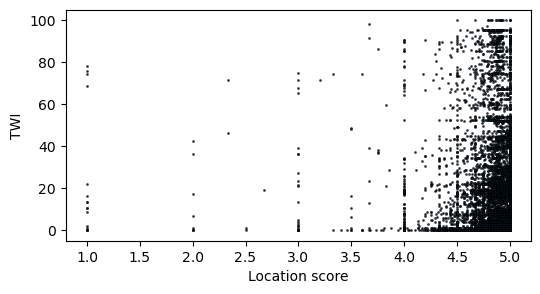

In [127]:
# Distribution of index as a function of location score
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(df["location_score"], df["TWI"], 
           s=1, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("Location score")
ax.set_ylabel("TWI")

In [128]:
# Index interval classification
conditions = [
    (df['TWI'] > 20) & (df['TWI'] <= 40),
    (df['TWI'] > 40) & (df['TWI'] <= 60),
    (df['TWI'] > 60) & (df['TWI'] <= 80),
    (df['TWI'] > 80) & (df['TWI'] <= 100)]
choices_quali = ['Basic', 'Average', 'High', 'Excelent']
choices_quant = [2, 3, 4, 5]
df['Walkability'] = np.select(conditions, choices_quali, default='Poor')
df['Walkability_num'] = np.select(conditions, choices_quant, default=1)

df

Hotel name  Longitude   Latitude  Count_A  Count_R  Metro_Tram_stop  \
0              1 -70.618800 -33.429590      1.0     19.0                1   
1              3 -70.608320 -33.421410      5.0     27.0                1   
2              4 -70.618660 -33.426290      1.0     13.0                1   
3              5 -70.621780 -33.428640      1.0     15.0                1   
4              6 -70.613040 -33.417360      6.0     17.0                0   
...          ...        ...        ...      ...      ...              ...   
7457        7886 -70.691359 -33.453342      0.0      0.0                1   
7458        7887 -70.644868 -33.447215      6.0      4.0                1   
7459        7888 -70.644818 -33.443328     11.0     11.0                1   
7460        7889 -70.670426 -33.436913      0.0      2.0                0   
7461        7890 -70.591978 -33.535151      0.0      0.0                0   

      Closeness_Centrality_Attractions  Closeness_Centrality_Restaurants  \
0                             0.000276                          0.000257   
1                             0.000220                          0.000250   
2                             0.000255                          0.000246   
3                             0.000293                          0.000253   
4                             0.000258                          0.000240   
...                                ...                               ...   
7457                          0.000137                          0.000111   
7458                          0.000284                          0.000189   
7459                          0.000316                          0.000199   
7460                          0.000226                          0.000143   
7461                          0.000072                          0.000072   

      amenities_count  Review_count_H  ...  Entertainment_Systems  \
0                  30              45  ...                      0   
1                  24             212  ...                      0   
2                  18              72  ...                      0   
3                   8              11  ...                      0   
4                   5               1  ...                      0   
...               ...             ...  ...                    ...   
7457                5               2  ...                      0   
7458               40               1  ...                      0   
7459                3               2  ...                      0   
7460               52               1  ...                      1   
7461               29               1  ...                      0   

      Miscellaneous  avg_price_log  Count_A_Z Count_R_Z  Bayes_mean_A  \
0                 0      10.842127  -0.530675  1.032855      4.292041   
1                 0      10.498333   0.321695  1.851896      4.521688   
2                 0      10.819758  -0.530675  0.418575      4.119788   
3                 0      10.819758  -0.530675  0.623335      4.292041   
4                 0      10.542020   0.534787  0.828095      4.454704   
...             ...            ...        ...       ...           ...   
7457              0      10.645187  -0.743768 -0.912365      0.000000   
7458              0      10.714418   0.534787 -0.502845      4.302935   
7459              0      10.454898   1.600250  0.213815      4.327512   
7460              0      10.322198  -0.743768 -0.707605      0.000000   
7461              0      10.518673  -0.743768 -0.912365      0.000000   

      Bayes_mean_R        TWI Walkability Walkability_num  
0         4.235982  21.396396       Basic               2  
1         4.272320  44.167617     Average               3  
2         4.269784  15.853952        Poor               1  
3         4.246583  17.701433        Poor               1  
4         4.307914  38.775536       Basic               2  
...            ...        ...         ...             ...  
7457      0.000000   0.000000        Poor 

<Axes: xlabel='Walkability', ylabel='Count'>

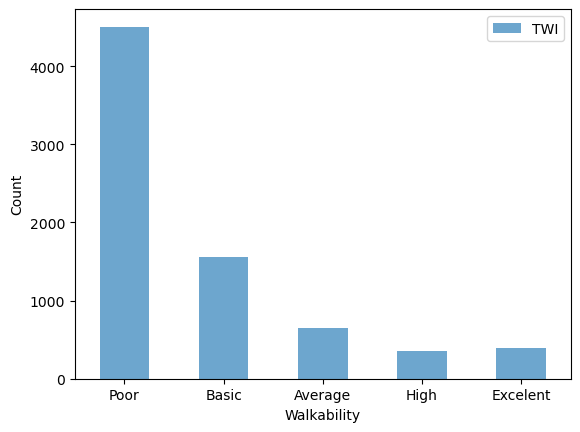

In [129]:
# Walkability index histogram
# Walkability index histogram
counts_for_plot = []
walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excelent']
for i in walkability_levels:
    if i in df.Walkability.values:
        counts_for_plot.append(len(df[df.Walkability == i]))
    else:
        counts_for_plot.append(0)
pd.DataFrame({"Walkability":walkability_levels, "TWI":counts_for_plot}).plot.bar(x="Walkability", alpha=0.65, xlabel="Walkability", ylabel="Count", rot=0)

In [130]:
test_map = keplergl.KeplerGl(height = 800, config=kepler_config)

test_map.add_data(data=df)
test_map.add_data(data=df2, name="Attractions")
test_map.add_data(data=df3, name="Restaurants")
test_map.add_data(data=df4, name="Metro/Tram")
test_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\mario\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message seri

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '2fxa7ht', 'type': …

In [131]:
test_map.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',

In [132]:
# Saving the map to html
test_map.save_to_html(file_name='kepler_map_Santiago_airbnb_15min.html')

Map saved to kepler_map_Santiago_airbnb_15min.html!


In [133]:
df["TWI"].to_excel("TWI_airbnb_Santiago.xlsx")

#### Price analysis

In [134]:
# Run this ONCE
df2 = df.copy()

In [135]:
df = df2

In [136]:
# Removing price outliers
Q1 = df['avg_price_log'].quantile(0.25)
Q3 = df['avg_price_log'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df = df[(df['avg_price_log'] >= Q1 - 1.5 * IQR) & (df['avg_price_log'] <= Q3 + 1.5 *IQR)]

In [137]:
df.host_is_superhost.value_counts()
#df = df[df.host_is_superhost == "f"]

host_is_superhost
f    4617
t    2686
Name: count, dtype: int64

In [139]:
df['neighbourhood_cleansed'].replace(["Macul", "San Miguel", "La Florida", "San Joaquín", "La Reina", "Maipú", 
    "Independencia", "Peñalolén", "La Cisterna", "Lo Barnechea", "Pudahuel", 
    "Quinta Normal", "Huechuraba", "Quilicura", "Lo Prado", "Renca", 
    "Cerrillos", "El Bosque", "Conchalí", "La Granja", "Cerro Navia", 
    "San Ramón"], "Others", inplace=True)
df['neighbourhood_cleansed'].value_counts()

C:\Users\mario\AppData\Local\Temp\ipykernel_17696\1934628304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['neighbourhood_cleansed'].replace(["Macul", "San Miguel", "La Florida", "San Joaquín", "La Reina", "Maipú",


neighbourhood_cleansed
Santiago            2726
Providencia         1591
Las Condes          1377
Others               586
Ñuñoa                575
Recoleta             162
Vitacura             151
Estación Central     135
Name: count, dtype: int64

In [140]:
df = df[(df.room_type == "Entire home/apt") | (df.room_type == "Private room")]
df.room_type.value_counts()

room_type
Entire home/apt    5789
Private room       1462
Name: count, dtype: int64

In [142]:
df['property_type'].replace(["Private room in casa particular", "Room in hotel", 
    "Private room in serviced apartment", "Private room in bed and breakfast", 
    "Entire vacation home", "Private room in guesthouse", 
    "Entire guesthouse", "Room in boutique hotel", "Private room in hostel", 
    "Private room in guest suite", "Entire guest suite", "Tiny home", 
    "Private room in townhouse", "Casa particular", "Private room in bungalow", 
    "Private room in vacation home", "Entire place", "Entire townhouse", 
    "Entire cabin", "Private room", "Private room in loft", 
    "Private room in earthen home", "Room in aparthotel", "Entire villa", 
    "Tower", "Private room in cabin", "Entire bungalow", 
    "Private room in minsu", "Private room in tiny home", 
    "Private room in cottage", "Entire chalet", "Private room in chalet", 
    "Camper/RV", "Private room in villa", "Private room in nature lodge", 
    "Ranch", "Entire cottage", "Castle", "Private room in castle", 
    "Shipping container", "Private room in treehouse", "Windmill", 
    "Private room in tower"]
, "Others", inplace=True)
df['property_type'].value_counts()

C:\Users\mario\AppData\Local\Temp\ipykernel_17696\2168236662.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['property_type'].replace(["Private room in casa particular", "Room in hotel",


property_type
Entire rental unit             4429
Entire condo                    633
Private room in rental unit     606
Others                          502
Private room in home            330
Entire serviced apartment       328
Entire loft                     170
Private room in condo           163
Entire home                      90
Name: count, dtype: int64

In [144]:
df.bathrooms = np.ceil(df.bathrooms)
df.bathrooms = df.bathrooms.astype("int")
df['bathrooms'] = np.where(df['bathrooms'] >= 3, 3, df['bathrooms'])
df.bathrooms.value_counts()

bathrooms
1    5370
2    1728
3     153
Name: count, dtype: int64

In [146]:
df = df[df.bedrooms >= 1]
df['bedrooms'] = np.where(df['bedrooms'] >= 3, 3, df['bedrooms'])
df.bedrooms.value_counts()

bedrooms
1    4972
2    1714
3     377
Name: count, dtype: int64

In [148]:
df['beds'] = np.where(df['beds'] >= 4, 4, df['beds'])
df.beds.value_counts()

beds
1    3552
2    1836
3    1039
4     636
Name: count, dtype: int64

In [149]:
df['host_response_time'], _ = pd.factorize(df['host_response_time'])
df['host_is_superhost'], _ = pd.factorize(df['host_is_superhost'])
df['neighbourhood_cleansed'], _ = pd.factorize(df['neighbourhood_cleansed'])
df['property_type'], _ = pd.factorize(df['property_type'])
df['room_type'], _ = pd.factorize(df['room_type'])
df['Walkability'], _ = pd.factorize(df['Walkability'])

In [150]:
# Get dummies
df_dummies = pd.get_dummies(df, columns = ["neighbourhood_cleansed",
                                          "property_type", "room_type", 
                                          "host_is_superhost", "bathrooms", 
                                          "bedrooms", "beds", "Walkability_num"], dtype = int)

In [151]:
df_dummies.drop(labels=['Hotel name', "Longitude", "Latitude", "Count_A", "Count_R", 
               "host_response_time", "host_response_rate", "host_acceptance_rate", 
               "Walkability", "Count_A_Z", "Count_R_Z"], axis=1, inplace=True)

In [152]:
# Export the DataFrame to Excel file
#df_dummies.to_excel("Venezia_dataframe_stat_analysis.xlsx")

In [153]:
len(df_dummies)

7063

In [ ]:
# amenities_count accommodates bathrooms bedrooms beds minimum_nights maximum_nights availability_365 
# review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication
# review_scores_value

#df_dummies.boxplot("Bayesian_avg_H")
#df_dummies.boxplot("Bayes_mean_A")
#df_dummies.boxplot("Bayes_mean_R")

#variables_outliers = ["TWI", "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", "amenities_count", "accommodates", 
#                      "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "availability_365"] #,
                      #"review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
                      #"review_scores_communication", "review_scores_value", "location_score"]
        
#variables_outliers = ["accommodates", "minimum_nights", "maximum_nights", "availability_365", "bathrooms", "bedrooms", "beds"]#

# Removing outliers
#for outlier in variables_outliers:
#    Q1 = df_dummies[outlier].quantile(0.25)
#    Q3 = df_dummies[outlier].quantile(0.75)
#    IQR = Q3 - Q1    #IQR is interquartile range. 
#    df_dummies = df_dummies[(df_dummies[outlier] >= Q1 - 1.5 * IQR) & (df_dummies[outlier] <= Q3 + 1.5 *IQR)]

In [154]:
len(df_dummies)

7063

In [155]:
# Scaling the variables that are not scalated
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()

In [156]:
columns_to_scale_avg_price = ["TWI", "accommodates", "minimum_nights", "maximum_nights", "availability_365", 
                             "amenities_count", "Bayesian_avg_H", 'review_scores_accuracy', 'review_scores_cleanliness',
                               'review_scores_checkin', 'review_scores_communication',
                               'review_scores_value', 'Bayes_mean_A', 'Bayes_mean_R', 'location_score', "Review_count_H", 
                             "Score_H"]

df_dummies_no_scale = df_dummies.copy()

df_dummies[columns_to_scale_avg_price] = scaler.fit_transform(df_dummies[columns_to_scale_avg_price])

C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  re

In [157]:
df_dummies.columns

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'amenities_count', 'Review_count_H',
       'Score_H', 'Bayesian_avg_H', 'price', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value', 'TVs', 'Wifi', 'Kitchen_Appliances', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'avg_price_log', 'Bayes_mean_A', 'Bayes_mean_R', 'TWI',
       'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'neighbourhood_cleansed_6', 'neighbourhood_cleansed_7',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4',

In [171]:
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency
binary_cols = ['Metro_Tram_stop', 'TVs', 'Wifi', 'Kitchen_Appliances', 'Parking',
       'Child_Amenities',  'Entertainment_Systems',
       'Miscellaneous', 'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'neighbourhood_cleansed_6', 'neighbourhood_cleansed_7',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5',
       'property_type_6', 'property_type_7', 'property_type_8', 'host_is_superhost_0', 'host_is_superhost_1',
       'bathrooms_1', 'bathrooms_2', 'bathrooms_3',
       'bedrooms_3', 'beds_2', 'beds_3',
       'Walkability_num_1', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5']
continuous_cols = ['amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
          'Bayes_mean_R']

# Initialize a list to store the results
correlation_results = []

# Compute point biserial correlation for each pair of binary and continuous variables
for binary_col in binary_cols:
    for continuous_col in continuous_cols:
        r_pb, p_value = pointbiserialr(df_dummies[binary_col], df_dummies[continuous_col])
        if r_pb >= 0.5 or r_pb <= -0.5:
            correlation_results.append({
                'type': 'Point Biserial',
                'variable1': binary_col,
                'variable2': continuous_col,
                'correlation': r_pb,
                'p_value': p_value
            })

# Compute Cramér's V for each pair of binary variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

for i, binary_col1 in enumerate(binary_cols):
    for binary_col2 in binary_cols[i+1:]:
        confusion_matrix = pd.crosstab(df_dummies[binary_col1], df_dummies[binary_col2])
        cramer_v = cramers_v(confusion_matrix)
        if cramer_v >= 0.5:
            correlation_results.append({
                'type': 'Cramér\'s V',
                'variable1': binary_col1,
                'variable2': binary_col2,
                'correlation': cramer_v,
                'p_value': None  # Cramér's V does not have a p-value
            })

# Compute Pearson correlation for each pair of continuous variables
for i, continuous_col1 in enumerate(continuous_cols):
    for continuous_col2 in continuous_cols[i+1:]:
        pearson_corr, p_value = pearsonr(df_dummies[continuous_col1], df_dummies[continuous_col2])
        if pearson_corr >= 0.5 or pearson_corr <= -0.5:
            correlation_results.append({
                'type': 'Pearson',
                'variable1': continuous_col1,
                'variable2': continuous_col2,
                'correlation': pearson_corr,
                'p_value': p_value
            })

# Display the results
for result in correlation_results:
    print(f"Type: {result['type']}, Var 1: {result['variable1']}, "
          f"Var 2: {result['variable2']}, Corr: {result['correlation']}, "
          f"P-value: {result.get('p_value', 'N/A')}")
    
# 'Closeness_Centrality_Attractions', 'Closeness_Centrality_Restaurants', 'bedrooms_1', 'beds_1', , 'beds_4'
# 'Score_H', 'room_type_0','room_type_1',, 'bedrooms_2' ,'review_scores_accuracy', 'review_scores_cleanliness',
# 'review_scores_checkin', 'review_scores_communication', 'review_scores_value',,
# 'neighbourhood_cleansed_2', 'Bathroom_Amenities', 'Bayes_mean_A',

Type: Cramér's V, Var 1: bathrooms_1, Var 2: bathrooms_2, Corr: 0.944112523355945, P-value: None
Type: Cramér's V, Var 1: Walkability_num_1, Var 2: Walkability_num_2, Corr: 0.635771492669291, P-value: None


In [ ]:
df_dummies.columns[:]

In [174]:
variables=['Metro_Tram_stop', 'TVs',  'Parking',
       'Child_Amenities',  'Entertainment_Systems',
       'Miscellaneous', 'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'neighbourhood_cleansed_6', 'neighbourhood_cleansed_7',
       'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5',
       'property_type_6', 'property_type_7', 'property_type_8', 'host_is_superhost_1',
       'bathrooms_2', 'bathrooms_3',
       'bedrooms_3', 'beds_2', 'beds_3',
       'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5', 'amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
          'Bayes_mean_R']
# Calculate VIF for the provided list of variables
vif_results = [
    (variables[i], variance_inflation_factor(df_dummies[variables].values, i))
    for i in range(len(variables))
    if variance_inflation_factor(df_dummies[variables].values, i) > 5
]
vif_results
# 'Kitchen_Appliances', 'Wifi',

[]

In [176]:
# Multiple linear regression
# Before removing high VIF variables
formula1 = ("avg_price_log ~ Kitchen_Appliances + Wifi + Metro_Tram_stop + TVs + Parking + Child_Amenities + Entertainment_Systems + Miscellaneous + neighbourhood_cleansed_0 + neighbourhood_cleansed_1 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + neighbourhood_cleansed_6 + neighbourhood_cleansed_7 + property_type_1 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + property_type_6 + property_type_7 + property_type_8 + host_is_superhost_1 + bathrooms_2 + bathrooms_3 + bedrooms_3 + beds_2 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + amenities_count + Review_count_H + Bayesian_avg_H + location_score + accommodates + minimum_nights + maximum_nights + availability_365 + Bayes_mean_R")

# After removing high VIF variables with the previous chunk
formula2 = ("avg_price_log ~ Metro_Tram_stop + TVs + Parking + Child_Amenities + Entertainment_Systems + Miscellaneous + neighbourhood_cleansed_0 + neighbourhood_cleansed_1 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + neighbourhood_cleansed_6 + neighbourhood_cleansed_7 + property_type_1 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + property_type_6 + property_type_7 + property_type_8 + host_is_superhost_1 + bathrooms_2 + bathrooms_3 + bedrooms_3 + beds_2 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + amenities_count + Review_count_H + Bayesian_avg_H + location_score + accommodates + minimum_nights + maximum_nights + availability_365 + Bayes_mean_R")

model_lr = ols(formula2,  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     295.1
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:44:49   Log-Likelihood:                -1740.7
No. Observations:                7063   AIC:                             3563.
Df Residuals:                    7022   BIC:                             3845.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.9051      0.015    707.551      0.000      10.875      10.935
Metro_Tram_stop              0.0063      0.010      0.633      0.527      -0.013       0.026
TVs                          0.0318      0.008      3.916      0.000       0.016       0.048
Parking                      0.0288      0.009      3.097      0.002       0.011       0.047
Child_Amenities              0.0714      0.010      7.018      0.000       0.051       0.091
Entertainment_Systems        0.0482      0.014      3.523      0.000       0.021       0.075
Miscellaneous               -0.0974      0.068     -1.441      0.150      -0.230       0.035
neighbourhood_cleansed_0    -0.1463      0.014    -10.499      0.000      -0.174      -0.119
neighbourhood_cleansed_1    -0.4001      0.018    -22.776      0.000      -0.435      -0.366
neighbourhood_cleansed_3    -0.5171      0.029    -18.070      0.000      -0.573      -0.461
neighbourhood_cleansed_4    -0.5123      0.013    -38.036      0.000      -0.539      -0.486
neighbourhood_cleansed_5     0.1465      0.027      5.350      0.000       0.093       0.200
neighbourhood_cleansed_6    -0.3614      0.017    -21.655      0.000      -0.394      -0.329
neighbourhood_cleansed_7    -0.5741      0.032    -18.195      0.000      -0.636      -0.512
property_type_1             -0.0041      0.014     -0.301      0.763      -0.031       0.023
property_type_2             -0.5444      0.019    -27.991      0.000      -0.582      -0.506
property_type_3             -0.2077      0.015    -13.440      0.000      -0.238      -0.177
property_type_4             -0.5336      0.026    -20.553      0.000      -0.584      -0.483
property_type_5              0.0578      0.018      3.159      0.002       0.022       0.094
property_type_6             -0.5063      0.015    -33.635      0.000      -0.536      -0.477
property_type_7              0.0160      0.025      0.641      0.521      -0.033       0.065
property_type_8              0.0925      0.035      2.628      0.009       0.023       0.161
host_is_superhost_1         -0.0324      0.009     -3.655      0.000      -0.050      -0.015
bathrooms_2                  0.1190      0.010     11.585      0.000       0.099       0.139
bathrooms_3                  0.1164      0.029      4.016      0.000       0.060       0.173
bedrooms_3                   0.0675      0.020      3.346      0.001       0.028       0.107
beds_2                       0.0139      0.009      1.526      0.127      -0.004       0.032
beds_3                       0.0459      0.012      3.779      0.000       0.022       0.070
Walkability_num_2            0.0268      0.011      2.518      0.012       0.006       0.048
Walkability_num_3            0.0550      0.014      3.815      0.000       0.027       0.083
Walkability_nu

In [177]:
# Perform backward elimination

while True:
    p_values = results_lr.pvalues.iloc[1:]  # Exclude intercept
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        formula = model_lr.formula.replace(f" + {excluded_feature}", "").replace(f"{excluded_feature} + ", "")
        model_lr = ols(formula, data=df_dummies)
        results_lr = model_lr.fit()
        print(f"Excluding {excluded_feature} with p-value {max_p_value}")
    else:
        break
results_lr.summary()

Excluding maximum_nights with p-value 0.8906731325305429
Excluding property_type_1 with p-value 0.7615526633278142
Excluding amenities_count with p-value 0.5333591847455494
Excluding property_type_7 with p-value 0.5126192276758089
Excluding Metro_Tram_stop with p-value 0.5082704704928834
Excluding location_score with p-value 0.3574191897735638
Excluding Miscellaneous with p-value 0.17129521487795304
Excluding beds_2 with p-value 0.1417954875749927


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     368.8
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:44:53   Log-Likelihood:                -1743.8
No. Observations:                7063   AIC:                             3554.
Df Residuals:                    7030   BIC:                             3780.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.9082      0.015    740.607      0.000      10.879      10.937
TVs                          0.0338      0.008      4.358      0.000       0.019       0.049
Parking                      0.0290      0.009      3.235      0.001       0.011       0.047
Child_Amenities              0.0696      0.010      7.250      0.000       0.051       0.088
Entertainment_Systems        0.0460      0.013      3.552      0.000       0.021       0.071
neighbourhood_cleansed_0    -0.1418      0.012    -11.609      0.000      -0.166      -0.118
neighbourhood_cleansed_1    -0.4003      0.017    -23.373      0.000      -0.434      -0.367
neighbourhood_cleansed_3    -0.5171      0.027    -18.824      0.000      -0.571      -0.463
neighbourhood_cleansed_4    -0.5096      0.011    -44.927      0.000      -0.532      -0.487
neighbourhood_cleansed_5     0.1472      0.027      5.378      0.000       0.094       0.201
neighbourhood_cleansed_6    -0.3584      0.016    -22.396      0.000      -0.390      -0.327
neighbourhood_cleansed_7    -0.5737      0.029    -19.496      0.000      -0.631      -0.516
property_type_2             -0.5455      0.019    -28.367      0.000      -0.583      -0.508
property_type_3             -0.2087      0.015    -13.673      0.000      -0.239      -0.179
property_type_4             -0.5351      0.026    -20.747      0.000      -0.586      -0.485
property_type_5              0.0562      0.018      3.096      0.002       0.021       0.092
property_type_6             -0.5079      0.015    -34.291      0.000      -0.537      -0.479
property_type_8              0.0906      0.035      2.585      0.010       0.022       0.159
host_is_superhost_1         -0.0332      0.009     -3.776      0.000      -0.050      -0.016
bathrooms_2                  0.1193      0.010     11.623      0.000       0.099       0.139
bathrooms_3                  0.1143      0.029      3.949      0.000       0.058       0.171
bedrooms_3                   0.0630      0.020      3.173      0.002       0.024       0.102
beds_3                       0.0403      0.012      3.492      0.000       0.018       0.063
Walkability_num_2            0.0282      0.011      2.672      0.008       0.007       0.049
Walkability_num_3            0.0574      0.014      4.011      0.000       0.029       0.085
Walkability_num_4            0.1551      0.019      8.078      0.000       0.117       0.193
Walkability_num_5            0.0888      0.018      4.838      0.000       0.053       0.125
Review_count_H              -0.0214      0.003     -8.176      0.000      -0.027      -0.016
Bayesian_avg_H               0.0202      0.004      4.813      0.000       0.012       0.028
accommodates                 0.2091      0.008     27.012      0.000       0.194       0.224
minimum_nights

In [178]:
model_lr.formula

'avg_price_log ~ TVs + Parking + Child_Amenities + Entertainment_Systems + neighbourhood_cleansed_0 + neighbourhood_cleansed_1 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + neighbourhood_cleansed_6 + neighbourhood_cleansed_7 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + property_type_6 + property_type_8 + host_is_superhost_1 + bathrooms_2 + bathrooms_3 + bedrooms_3 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Review_count_H + Bayesian_avg_H + accommodates + minimum_nights + availability_365 + Bayes_mean_R'

In [184]:
# Multiple linear regression

model_lr = ols('avg_price_log ~  TVs + Parking + Child_Amenities + Entertainment_Systems + neighbourhood_cleansed_0 + neighbourhood_cleansed_1 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + neighbourhood_cleansed_6 + neighbourhood_cleansed_7 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + property_type_6 + property_type_8 + host_is_superhost_1 + bathrooms_2 + bathrooms_3 + bedrooms_3 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Review_count_H + Bayesian_avg_H + accommodates + minimum_nights + availability_365 + Bayes_mean_R',  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     368.8
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:46:37   Log-Likelihood:                -1743.8
No. Observations:                7063   AIC:                             3554.
Df Residuals:                    7030   BIC:                             3780.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.9082      0.015    740.607      0.000      10.879      10.937
TVs                          0.0338      0.008      4.358      0.000       0.019       0.049
Parking                      0.0290      0.009      3.235      0.001       0.011       0.047
Child_Amenities              0.0696      0.010      7.250      0.000       0.051       0.088
Entertainment_Systems        0.0460      0.013      3.552      0.000       0.021       0.071
neighbourhood_cleansed_0    -0.1418      0.012    -11.609      0.000      -0.166      -0.118
neighbourhood_cleansed_1    -0.4003      0.017    -23.373      0.000      -0.434      -0.367
neighbourhood_cleansed_3    -0.5171      0.027    -18.824      0.000      -0.571      -0.463
neighbourhood_cleansed_4    -0.5096      0.011    -44.927      0.000      -0.532      -0.487
neighbourhood_cleansed_5     0.1472      0.027      5.378      0.000       0.094       0.201
neighbourhood_cleansed_6    -0.3584      0.016    -22.396      0.000      -0.390      -0.327
neighbourhood_cleansed_7    -0.5737      0.029    -19.496      0.000      -0.631      -0.516
property_type_2             -0.5455      0.019    -28.367      0.000      -0.583      -0.508
property_type_3             -0.2087      0.015    -13.673      0.000      -0.239      -0.179
property_type_4             -0.5351      0.026    -20.747      0.000      -0.586      -0.485
property_type_5              0.0562      0.018      3.096      0.002       0.021       0.092
property_type_6             -0.5079      0.015    -34.291      0.000      -0.537      -0.479
property_type_8              0.0906      0.035      2.585      0.010       0.022       0.159
host_is_superhost_1         -0.0332      0.009     -3.776      0.000      -0.050      -0.016
bathrooms_2                  0.1193      0.010     11.623      0.000       0.099       0.139
bathrooms_3                  0.1143      0.029      3.949      0.000       0.058       0.171
bedrooms_3                   0.0630      0.020      3.173      0.002       0.024       0.102
beds_3                       0.0403      0.012      3.492      0.000       0.018       0.063
Walkability_num_2            0.0282      0.011      2.672      0.008       0.007       0.049
Walkability_num_3            0.0574      0.014      4.011      0.000       0.029       0.085
Walkability_num_4            0.1551      0.019      8.078      0.000       0.117       0.193
Walkability_num_5            0.0888      0.018      4.838      0.000       0.053       0.125
Review_count_H              -0.0214      0.003     -8.176      0.000      -0.027      -0.016
Bayesian_avg_H               0.0202      0.004      4.813      0.000       0.012       0.028
accommodates                 0.2091      0.008     27.012      0.000       0.194       0.224
minimum_nights

In [185]:
# Variance Inflation Factor (impact over Standard Error (accuracy of estimated coefficients))
# [(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index)))]
[(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index))) if variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i) > 5]

[]

ShapiroResult(statistic=0.9641614556312561, pvalue=1.3104867568248616e-38)
Kolmogorov-Smirnov test: Statistic=0.05977453715583214, p-value=2.224279172883205e-22


C:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


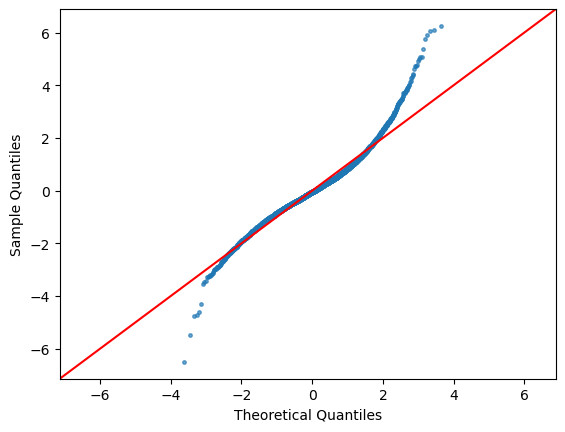

In [186]:
## Assessing normality of residuals Shapiro-Wilk test and QQ-plot
# Null hypothesis: residuals follow a normal distribution
residuals_lr = results_lr.resid
print(shapiro(residuals_lr))
ks_test = kstest(residuals_lr, 'norm', args=(np.mean(residuals_lr), np.std(residuals_lr)))
print(f"Kolmogorov-Smirnov test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
fig = sm.qqplot(residuals_lr, fit=True, line="45", alpha=0.65, markersize=2.5)
plt.show()

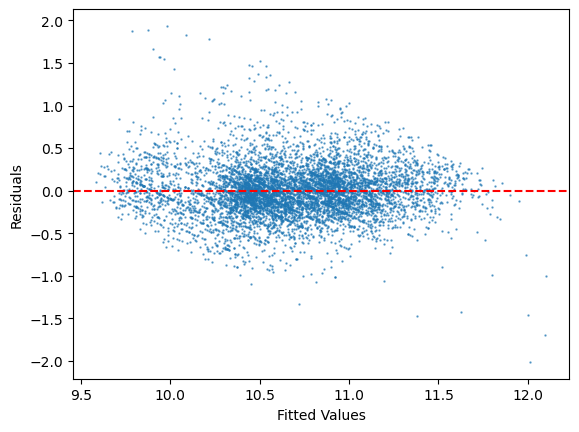

In [187]:
## Assessing linearity: Residual plot
fitted_values_lr = results_lr.fittedvalues
#plt.scatter(fitted_values_lr, np.sqrt(np.abs(residuals_lr/np.std(residuals_lr))), alpha=0.65, s=0.5)
plt.scatter(fitted_values_lr, residuals_lr, alpha=0.65, s=0.5)
plt.axhline(y=0, color='red', label='y=0', linestyle="--", linewidth=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

C:\Users\mario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


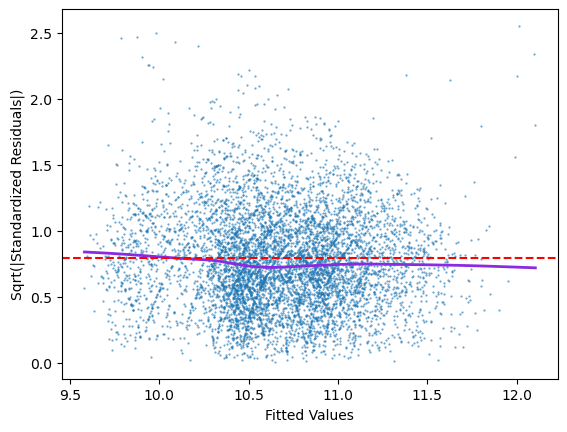

In [188]:
## Assessing homoscedasticity: Residual plot
import seaborn as sns

# Obtain fitted values and residuals from your model
residuals_lr = results_lr.resid

# Standardize residuals
standardized_residuals_lr = residuals_lr / np.std(residuals_lr)

# Compute square root of absolute standardized residuals
sqrt_abs_resid_lr = np.sqrt(np.abs(standardized_residuals_lr))

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Fitted Values': fitted_values_lr,
    'Sqrt Abs Standardized Residuals': sqrt_abs_resid_lr
})

# Create the Scale-Location plot with LOESS line
#plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, alpha=0.65, s=2, edgecolor='#1f77b4')
sns.regplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, scatter=False, 
            lowess=True, color="blueviolet", line_kws=dict(linestyle="-", linewidth=2))
plt.axhline(y=np.sqrt(2/np.pi), color='red', linestyle='--', lw=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Sqrt(|Standardized Residuals|)")
#plt.title("Scale-Location Plot with LOESS Smoothing")
#plt.legend()
plt.show()

In [ ]:
### Establishing study case


## Get the scale and center values for variables
# IQR:
scale_value6 = scaler.scale_[6]
scale_value5 = scaler.scale_[5]
scale_value15 = scaler.scale_[15]
scale_value14 = scaler.scale_[14]
scale_value1 = scaler.scale_[1]
scale_value3 = scaler.scale_[3]
scale_value4 = scaler.scale_[4]

# Median:
center_value6 = scaler.center_[6]
center_value5 = scaler.center_[5]
center_value15 = scaler.center_[15]
center_value14 = scaler.center_[14]
center_value1 = scaler.center_[1]
center_value3 = scaler.center_[3]
center_value4 = scaler.center_[4]

# Defining values for numerical variables (use following chunk as reference for these values)
# This is the median case
var6 = 4.746502003234805 # Median
var5 = 28 # Median
var15 = 59 # Median
var14 = 4.92 # Median
var1 = 4 # Median
var3 = 365 # Median
var4 = 185 # Median

# Transform
transformed_value6 = (var6 - center_value6) / scale_value6
transformed_value5 = (var5 - center_value5) / scale_value5
transformed_value15 = (var15 - center_value15) / scale_value15
transformed_value14 = (var14 - center_value14) / scale_value14
transformed_value1 = (var1 - center_value1) / scale_value1
transformed_value3 = (var3 - center_value3) / scale_value3
transformed_value4 = (var4 - center_value4) / scale_value4

print("transformed_value6:", transformed_value6, "transformed_value5:", transformed_value5, 
     "transformed_value15:", transformed_value15, "transformed_value14:", transformed_value14,
     "transformed_value1:", transformed_value1, "transformed_value3:", transformed_value3, 
      "transformed_value4:", transformed_value4)

In [ ]:
columns_to_scale_avg_price

In [ ]:
model_lr.formula

In [ ]:
df_dummies_no_scale["Bayesian_avg_H"].median()

In [ ]:
## Defining study case
study_case = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0]

In [ ]:
new_data = pd.DataFrame({'const':[1],
                         "Walkability_num_2":study_case[0],
                         "Walkability_num_3":study_case[1],
                         "Walkability_num_4":study_case[2],
                         "Walkability_num_5":study_case[3],
                         "Bayesian_avg_H":study_case[4],
                         "TVs":study_case[5],
                         "Bathroom_Amenities":study_case[6],
                         "neighbourhood_cleansed_4":study_case[7],
                         "property_type_1":study_case[8],
                         "property_type_4":study_case[9],
                         "bathrooms_2":study_case[10],
                         "bathrooms_3":study_case[11],
                         "bedrooms_2":study_case[12],
                         "beds_2":study_case[13],
                         "beds_3":study_case[14],
                         "amenities_count":study_case[15],
                         "Review_count_H":study_case[16],
                         "location_score":study_case[17],
                         "accommodates":study_case[18],
                         "maximum_nights":study_case[19],
                         "availability_365":study_case[20],
})

predictions = results_lr.get_prediction(new_data)
df_predictions = predictions.summary_frame()
np.exp(df_predictions)

In [ ]:
x_walk_score = ["Poor", "Basic", "Average", "High", "Excellent"]
point_estimate_y = [138.619241, 149.553616, 158.72416, 159.525814, 161.127639]

In [ ]:
# Create DataFrame
df_point_estimate = pd.DataFrame({
    "Walkability": x_walk_score,
    "point_estimate_y": point_estimate_y,
})

# Plot the DataFrame
ax = df_point_estimate.plot.bar(x="Walkability", y="point_estimate_y", 
                 color=["#1f77b4"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Price", rot=0, legend=False)
ax.set_ylim([0, 175])

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Price")
#plt.title("Comparison of Counts by Walkability Levels")

# Show plot
plt.show()

In [189]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor, export_graphviz  
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [194]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a regressor object 
## Using GridSearchCV over min_samples_leaf
regressor = DecisionTreeRegressor(random_state = 42)

# Define X and y data 
df_dummies_dropna = df_dummies_no_scale.dropna(subset="price")
var_considered = ['Metro_Tram_stop', 'TVs', 'Wifi', 'Kitchen_Appliances', 'Parking',
       'Child_Amenities',  'Entertainment_Systems',
       'Miscellaneous', 'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'neighbourhood_cleansed_6', 'neighbourhood_cleansed_7',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5',
       'property_type_6', 'property_type_7', 'property_type_8', 'host_is_superhost_0', 'host_is_superhost_1',
       'bathrooms_1', 'bathrooms_2', 'bathrooms_3',
       'bedrooms_3', 'beds_2', 'beds_3',
       "TWI", 'amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
          'Bayes_mean_R']
#var_considered = ["Walkability_num_2", "Walkability_num_3", "Walkability_num_4", "Walkability_num_5"]

X=df_dummies_dropna[var_considered]

# "Closeness_Centrality_Restaurants", "Closeness_Centrality_Restaurants",
y=df_dummies_dropna.price

# Split the data into training and testing sets (80-20 split)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for min_samples_leaf
#param_grid = {"min_samples_leaf":[2]} # 
param_grid = {
    #'max_depth': np.arange(10, 30), # np.arange(5, 16)
    #'min_samples_split': np.arange(10, 100),
    'min_samples_leaf': np.arange(70, 100) # np.arange(5, 15)
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring="r2")

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameter value
#best_max_depth = grid_search.best_params_["max_depth"]
#best_min_samples_split = grid_search.best_params_["min_samples_split"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
#print(f"Best max_depth: {best_max_depth}")
#print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best min_samples_leaf
final_model = DecisionTreeRegressor(min_samples_leaf=best_min_samples_leaf)

final_model.fit(X, y)

# Predict the entire dataset
y_pred = final_model.predict(X)

# Calculate evalation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

#mse_scores = -cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")
#r2_scores = cross_val_score(final_model, X, y, cv=5, scoring="r2")

# Calculate mean and std of MSE
#mean_mse_scores = np.mean(mse_scores)
#std_mse_scores = np.std(mse_scores)
#mean_r2_scores = np.mean(r2_scores)
#std_r2_scores = np.std(r2_scores)

#print(f"Mean MSE: {mean_mse_scores}")
#print(f"Std MSE: {std_mse_scores}")
#print(f"Mean R^2: {mean_r2_scores}")
#print(f"Std R^2: {std_r2_scores}")

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {1-(1-r2)*(len(X)-1)/(len(X)-len(var_considered)-1)}")

Best min_samples_leaf: 71
MSE: 314986463.2469316
R^2: 0.5569244437795368
Adj R^2: 0.554273564383346


In [195]:
print("mean_test_score:" , grid_search.cv_results_["mean_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("std_test_score:" , grid_search.cv_results_["std_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("rank_test_score:" , grid_search.cv_results_["rank_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])

mean_test_score: 0.4774318517469348
std_test_score: 0.026682308354671846
rank_test_score: 1


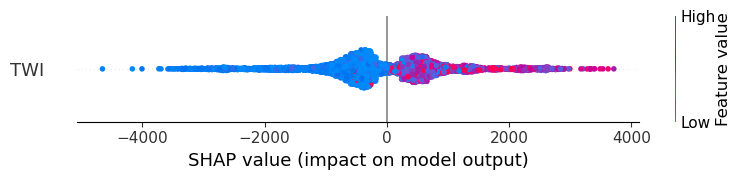

In [228]:
import shap
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X, max_display=50)
shap.summary_plot(shap_values[:, 32:33], X.iloc[:, 32:33], max_display=50)

In [ ]:
# Predict on the testing data (if train_test_split in the previous chunk is uncommented)
#y_pred = final_model.predict(X_test)

# Calculate evaluation metrics on the testing data
#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(var_considered) - 1)

#print(f"MSE: {mse}")
#print(f"R^2: {r2}")
#print(f"Adjusted R^2: {adj_r2}")

In [229]:
# Feature importance
j = 0
var_considered_filtered = []
for feature in var_considered:
    print(feature, final_model.feature_importances_[j])
    
    if final_model.feature_importances_[j] > 0:
        var_considered_filtered.append(feature)
        
    j += 1

Metro_Tram_stop 0.009849141461489554
TVs 0.0008191651472631549
Wifi 0.0
Kitchen_Appliances 0.0
Parking 0.00016502436744908646
Child_Amenities 0.008190387647108674
Entertainment_Systems 0.0
Miscellaneous 0.0
neighbourhood_cleansed_0 0.008809336803852189
neighbourhood_cleansed_1 0.016444611248313746
neighbourhood_cleansed_3 0.0
neighbourhood_cleansed_4 0.20814986074433126
neighbourhood_cleansed_5 0.0
neighbourhood_cleansed_6 0.0002761159691719997
neighbourhood_cleansed_7 0.008890715477436318
property_type_0 0.005289564561233707
property_type_1 0.0
property_type_2 0.012984236268135023
property_type_3 0.0
property_type_4 0.0
property_type_5 0.0
property_type_6 0.0
property_type_7 0.0
property_type_8 0.0
host_is_superhost_0 0.0
host_is_superhost_1 0.0
bathrooms_1 0.03138208412431067
bathrooms_2 0.0034399131658816103
bathrooms_3 0.0
bedrooms_3 0.0
beds_2 0.0
beds_3 0.0
TWI 0.008840929641788516
amenities_count 0.008862818857869239
Review_count_H 0.003700889946518588
Bayesian_avg_H 0.001312657

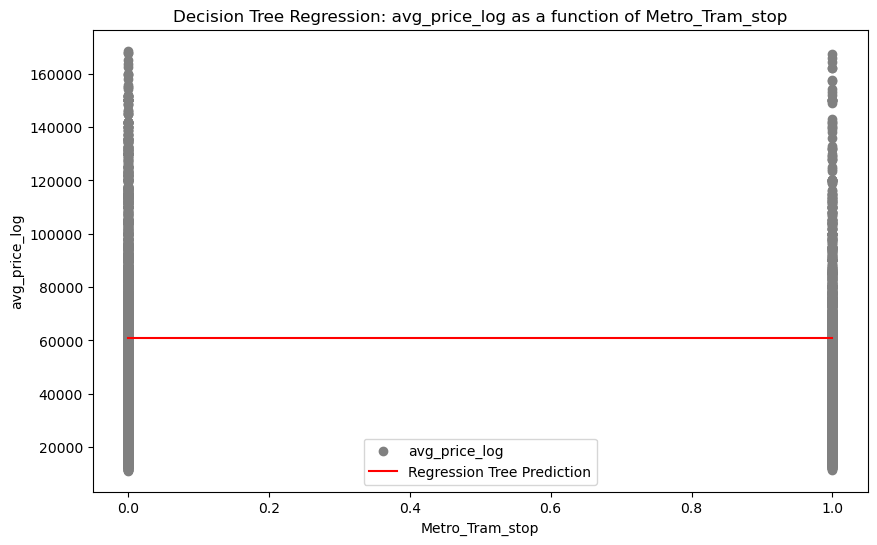

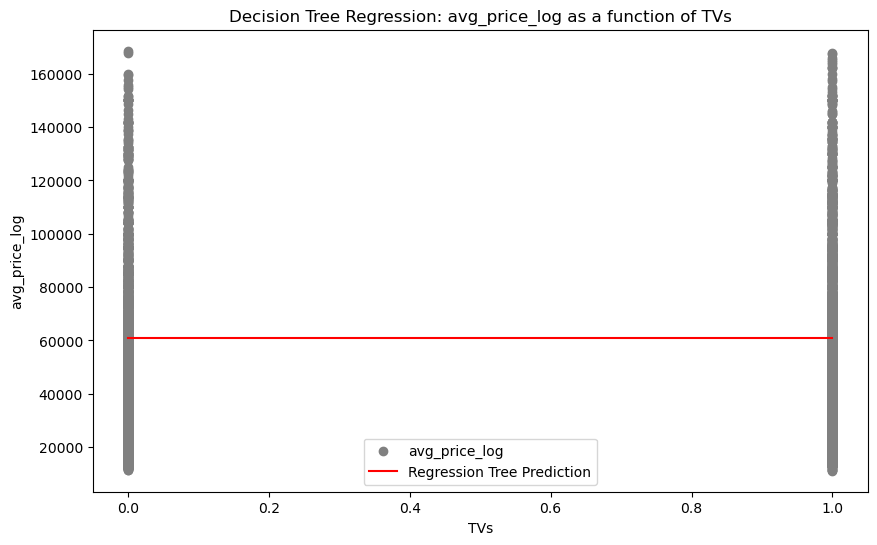

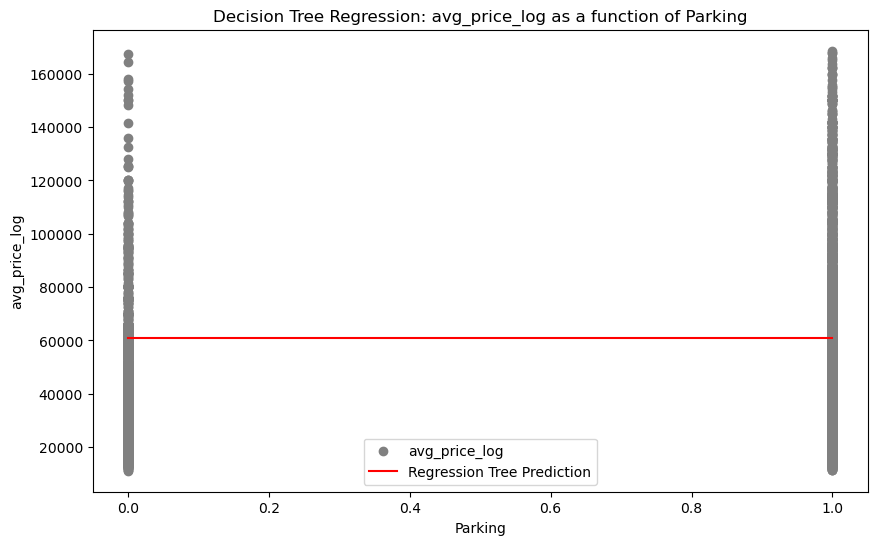

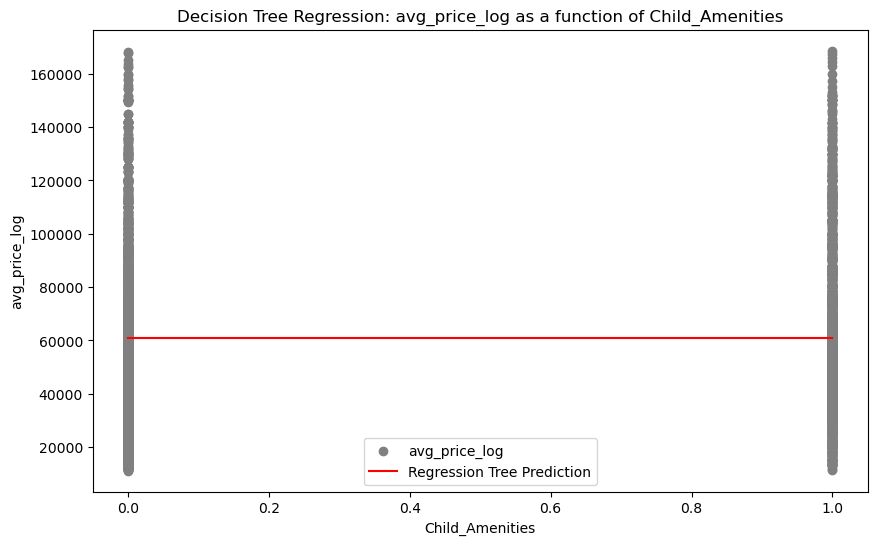

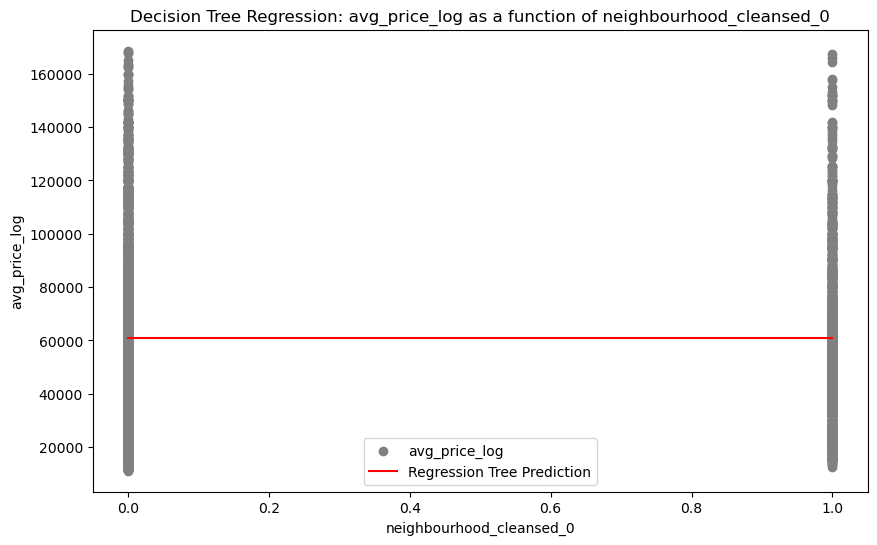

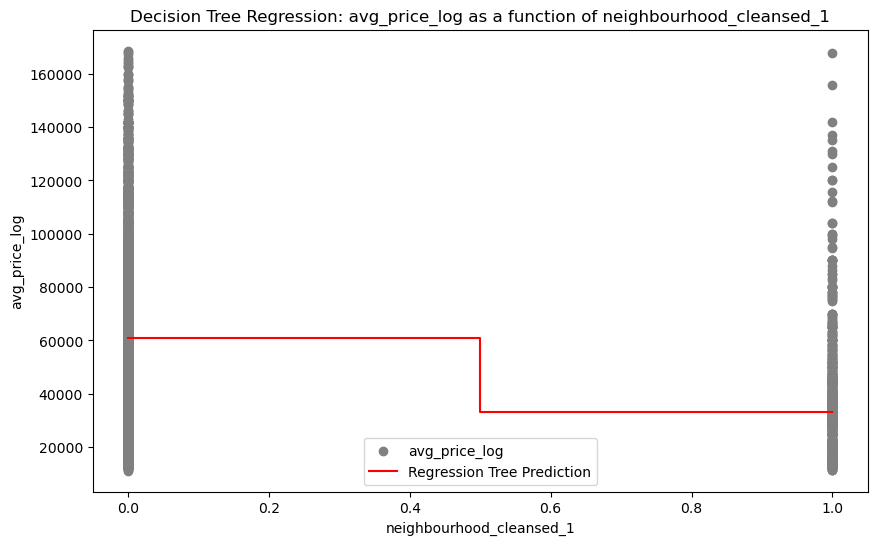

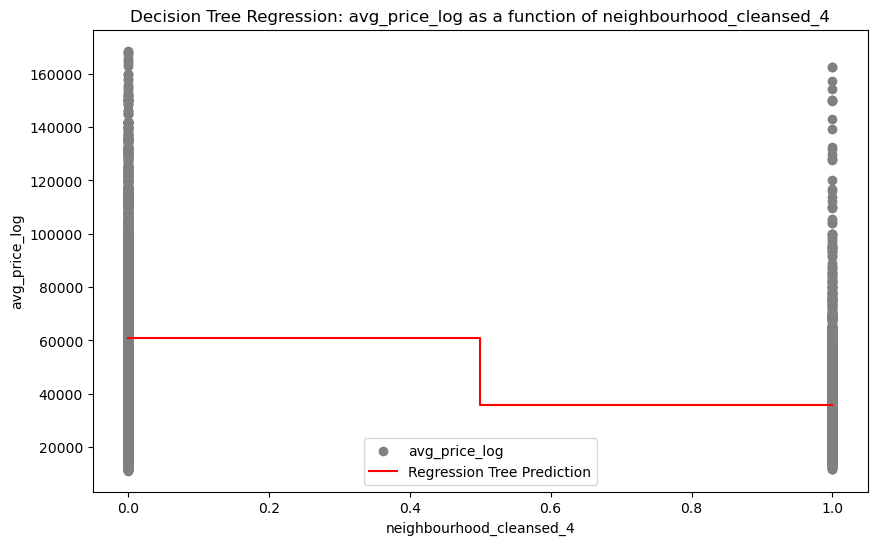

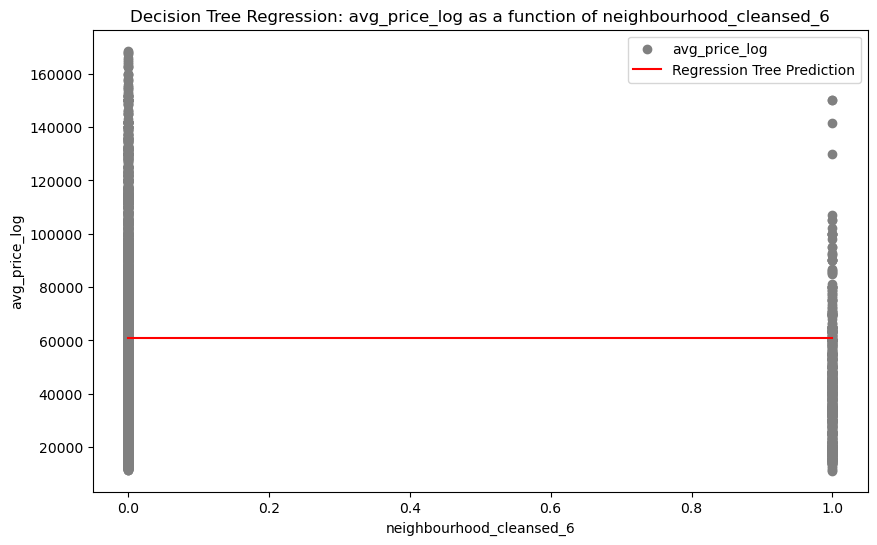

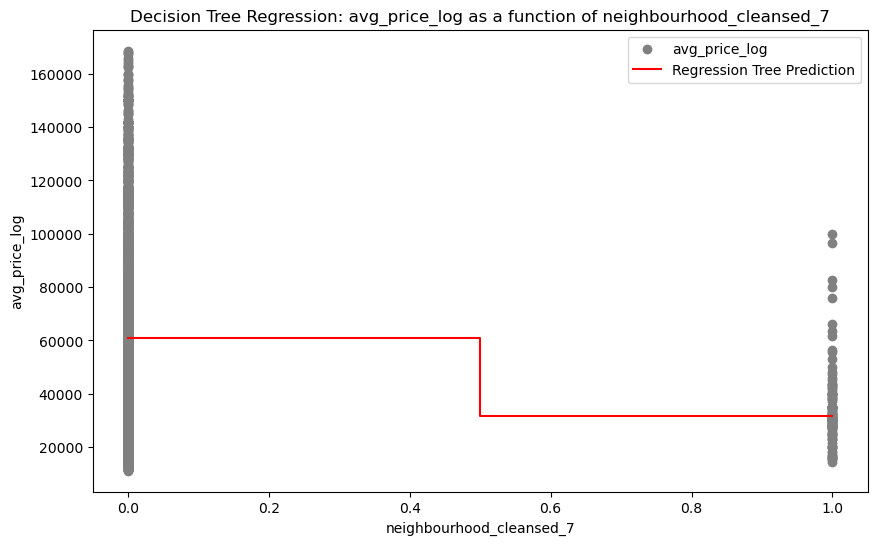

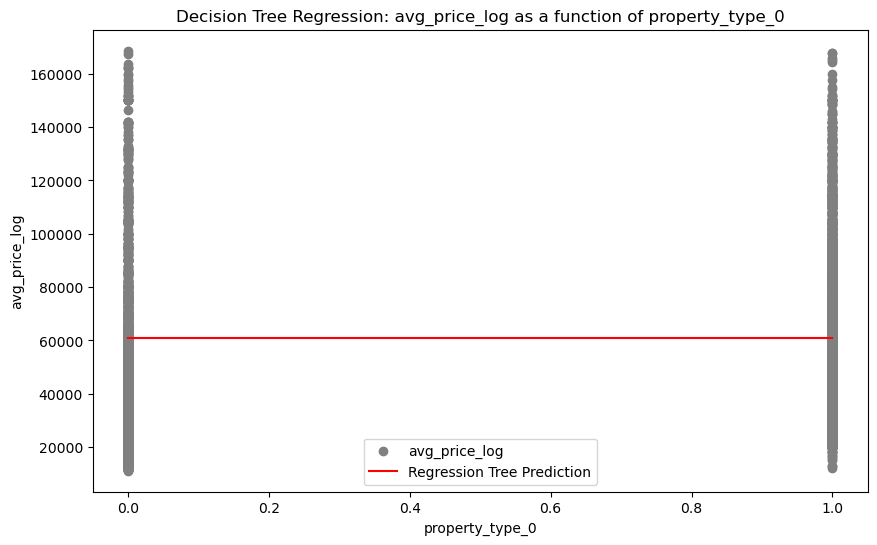

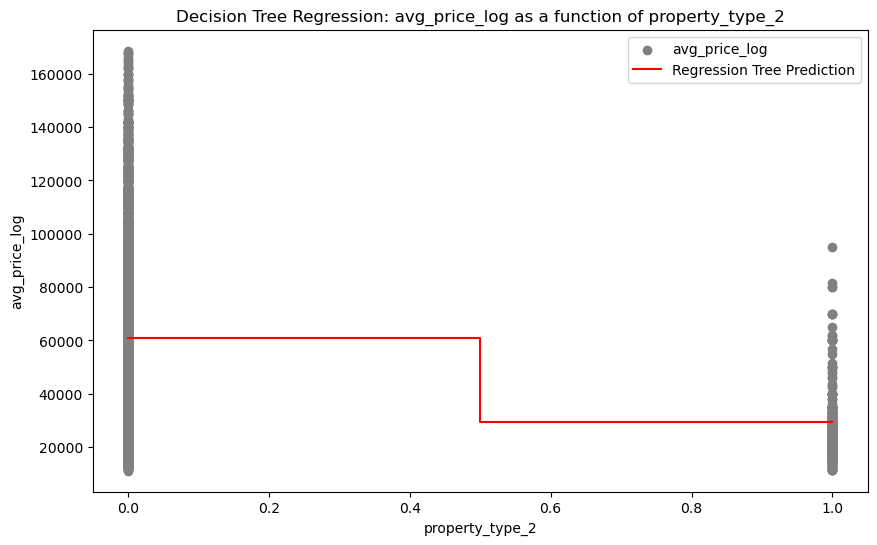

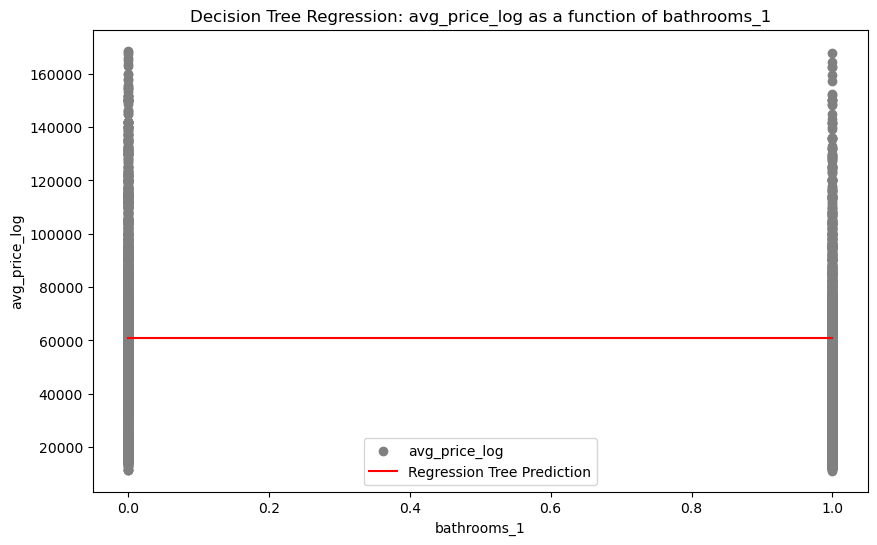

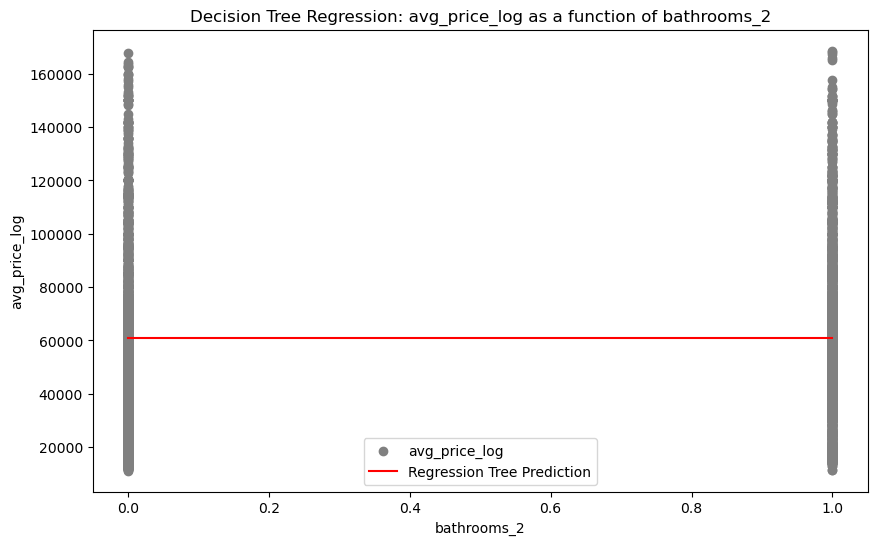

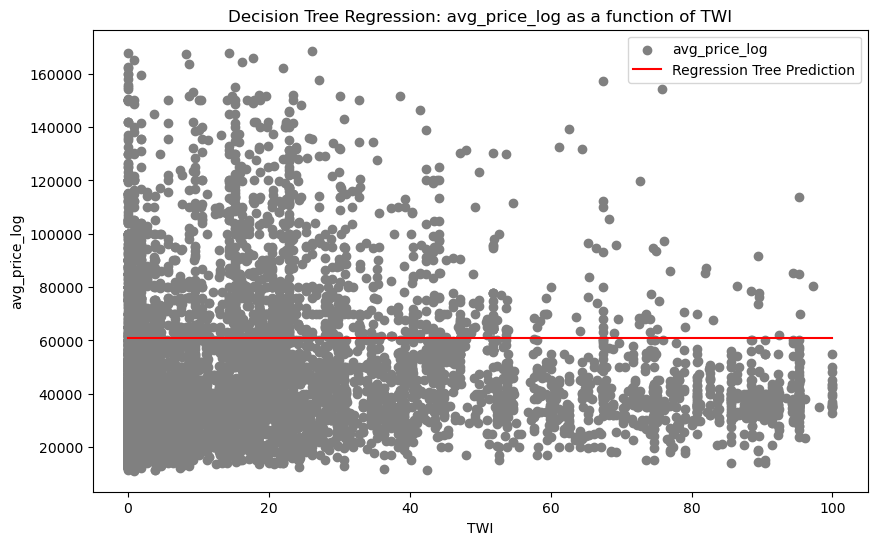

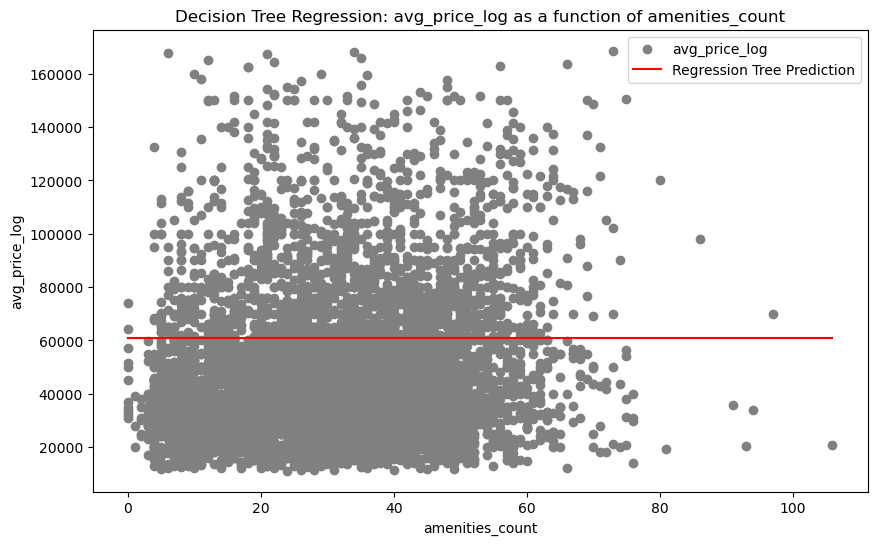

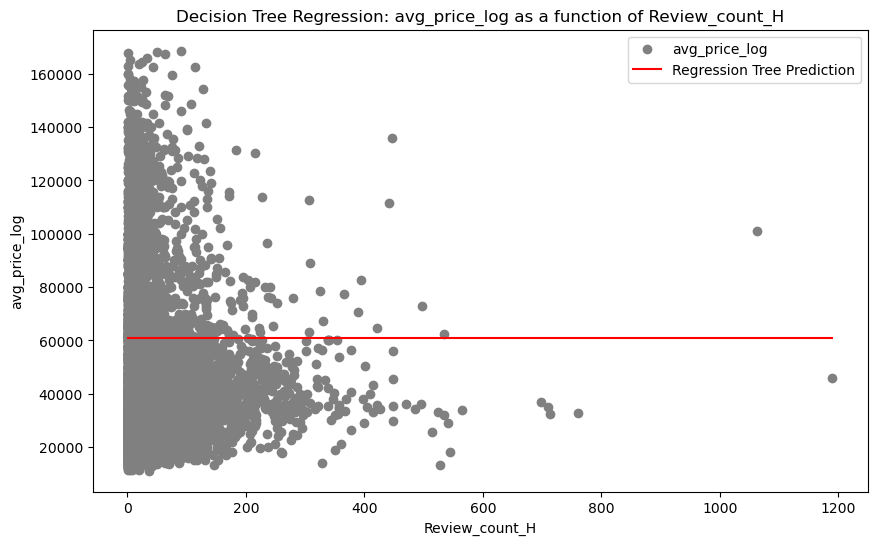

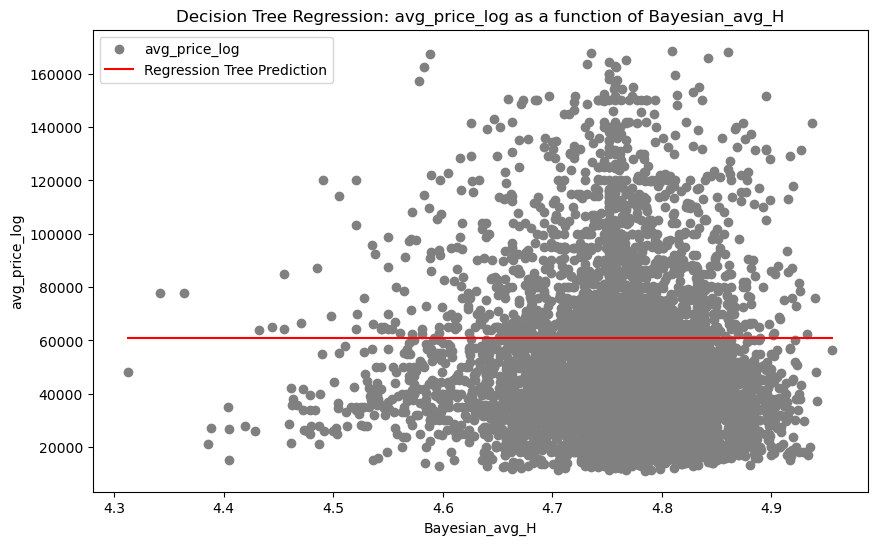

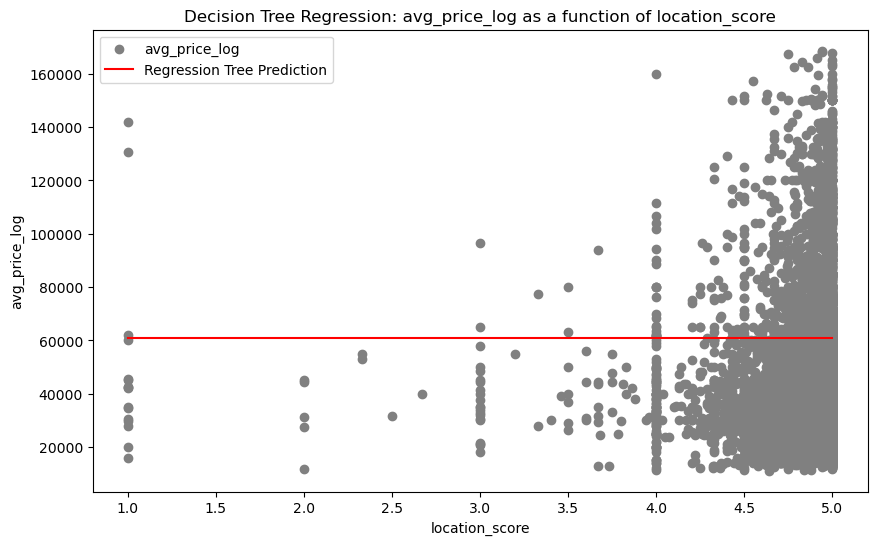

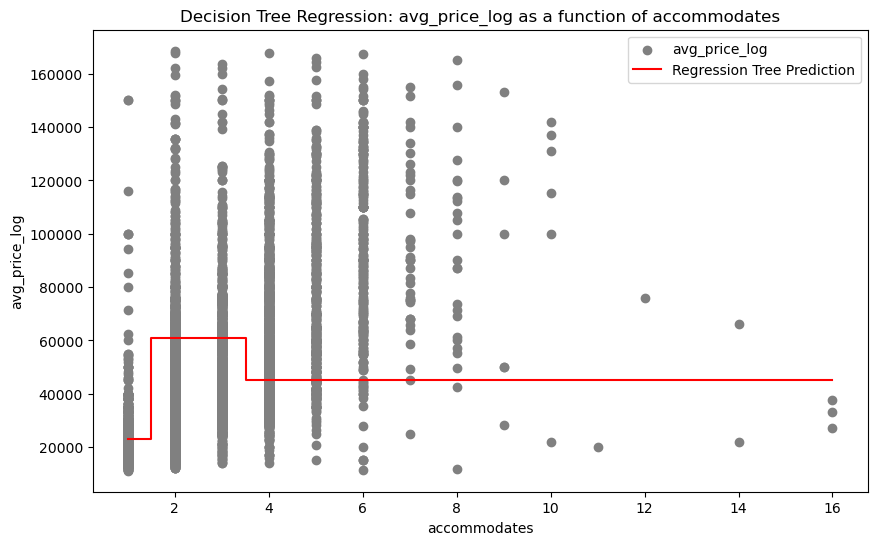

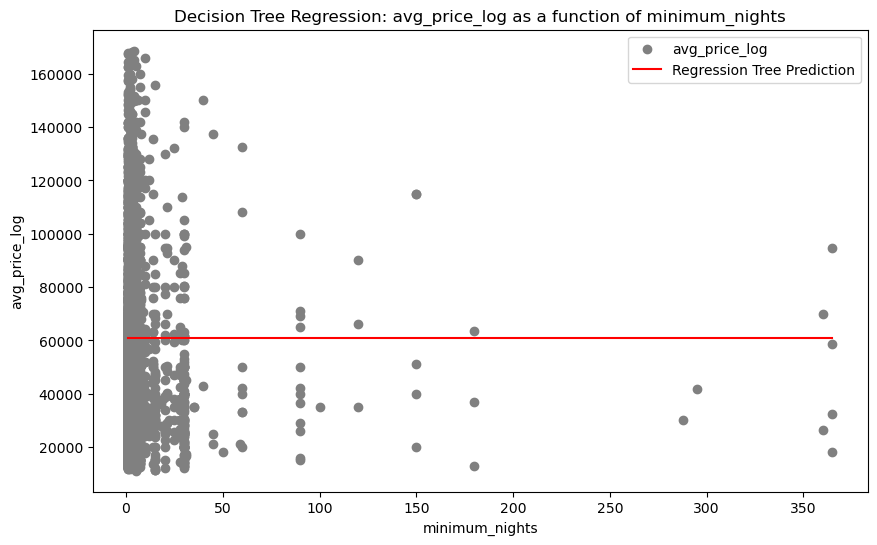

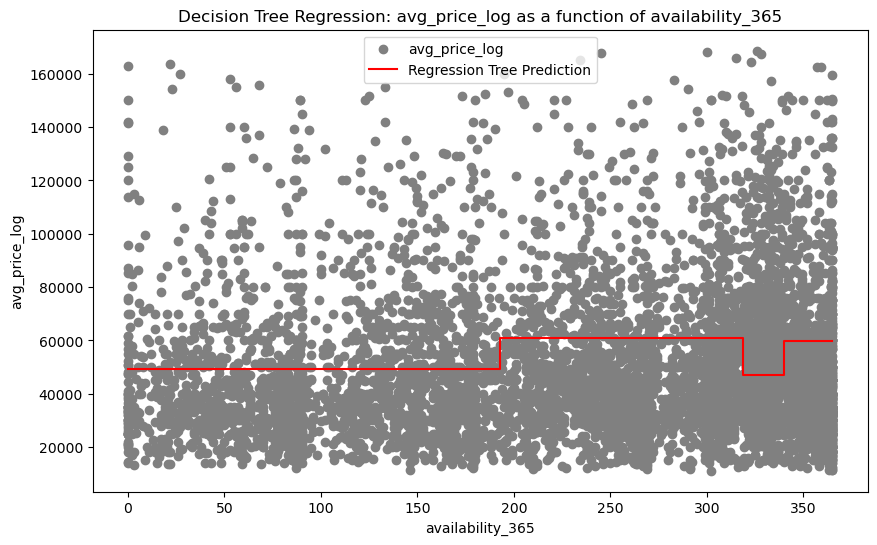

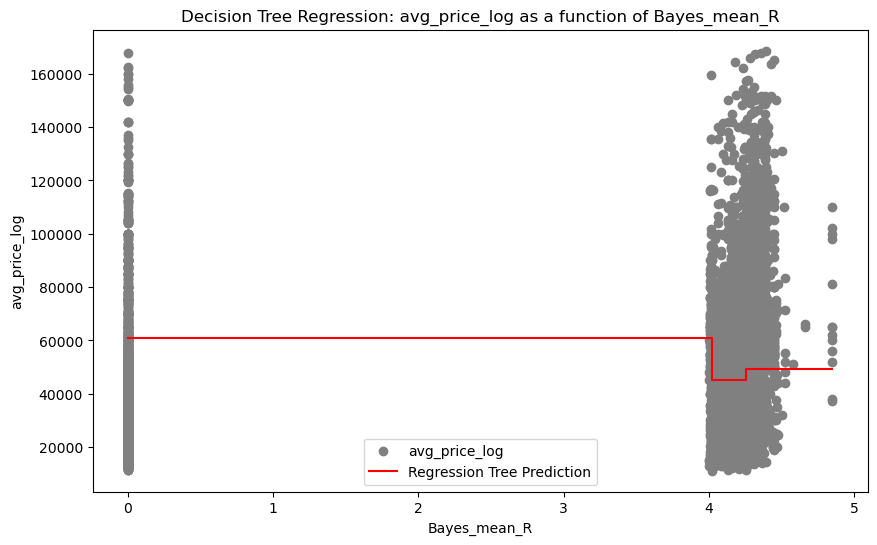

In [230]:
# Function to plot the decision tree predictions for a given feature
def plot_feature_decision_boundary(feature_name, output_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot of the feature vs avg_price
    plt.scatter(X[feature_name], y, color='gray', label=output_label)

    # Create a grid of feature values
    feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), 500)

    # Create a grid of input features
    X_grid = pd.DataFrame(np.tile(X.mean().values, (500, 1)), columns=X.columns)
    X_grid[feature_name] = feature_values

    # Predict avg_price for the grid values
    y_grid_pred = final_model.predict(X_grid)

    # Plot the decision boundary
    plt.step(feature_values, y_grid_pred, color='red', label='Regression Tree Prediction', where='mid')

    plt.xlabel(feature_name)
    plt.ylabel(output_label)
    plt.title(f"Decision Tree Regression: {output_label} as a function of {feature_name}")
    plt.legend()
    plt.show()

# Plot decision boundaries for each feature
for feature in var_considered_filtered:
    plot_feature_decision_boundary(feature, "avg_price_log")

In [231]:
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
# https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0D%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0D%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0D%0A0%20%5Blabel%3D%22TWI%20%3C%3D%208.771%5Cnsquared_error%20%3D%20454.476%5Cnsamples%20%3D%2018%5Cnvalue%20%3D%20117.694%22%5D%20%3B%0D%0A1%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%2062.776%5Cnsamples%20%3D%207%5Cnvalue%20%3D%2098.286%22%5D%20%3B%0D%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0D%0A2%20%5Blabel%3D%22TWI%20%3C%3D%200.954%5Cnsquared_error%20%3D%2019.297%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20104.375%22%5D%20%3B%0D%0A1%20-%3E%202%20%3B%0D%0A3%20%5Blabel%3D%22squared_error%20%3D%2033.062%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20102.75%22%5D%20%3B%0D%0A2%20-%3E%203%20%3B%0D%0A4%20%5Blabel%3D%22squared_error%20%3D%200.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20106.0%22%5D%20%3B%0D%0A2%20-%3E%204%20%3B%0D%0A5%20%5Blabel%3D%22squared_error%20%3D%205.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%2090.167%22%5D%20%3B%0D%0A1%20-%3E%205%20%3B%0D%0A6%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%20311.475%5Cnsamples%20%3D%2011%5Cnvalue%20%3D%20130.045%22%5D%20%3B%0D%0A0%20-%3E%206%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0D%0A7%20%5Blabel%3D%22squared_error%20%3D%20269.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%20150.333%22%5D%20%3B%0D%0A6%20-%3E%207%20%3B%0D%0A8%20%5Blabel%3D%22TWI%20%3C%3D%2059.023%5Cnsquared_error%20%3D%20115.027%5Cnsamples%20%3D%208%5Cnvalue%20%3D%20122.438%22%5D%20%3B%0D%0A6%20-%3E%208%20%3B%0D%0A9%20%5Blabel%3D%22TWI%20%3C%3D%2039.613%5Cnsquared_error%20%3D%204.922%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20129.625%22%5D%20%3B%0D%0A8%20-%3E%209%20%3B%0D%0A10%20%5Blabel%3D%22squared_error%20%3D%200.562%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20129.25%22%5D%20%3B%0D%0A9%20-%3E%2010%20%3B%0D%0A11%20%5Blabel%3D%22squared_error%20%3D%209.0%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20130.0%22%5D%20%3B%0D%0A9%20-%3E%2011%20%3B%0D%0A12%20%5Blabel%3D%22TWI%20%3C%3D%2071.824%5Cnsquared_error%20%3D%20121.812%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20115.25%22%5D%20%3B%0D%0A8%20-%3E%2012%20%3B%0D%0A13%20%5Blabel%3D%22squared_error%20%3D%20240.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20114.5%22%5D%20%3B%0D%0A12%20-%3E%2013%20%3B%0D%0A14%20%5Blabel%3D%22squared_error%20%3D%202.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20116.0%22%5D%20%3B%0D%0A12%20-%3E%2014%20%3B%0D%0A%7D
export_graphviz(final_model, out_file ='tree_Santiago_avg_price_log_airbnb.dot', 
               feature_names = var_considered)  

#### GAM

In [ ]:
GAM_fit = True
if GAM_fit:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Install pyGAM
# !pip install pygam
if GAM_fit:
    from pygam import LinearGAM, s, f, l

    X=X[['neighbourhood_cleansed_0',
                   'neighbourhood_cleansed_1', 'neighbourhood_cleansed_2',
                   'neighbourhood_cleansed_3', 'neighbourhood_cleansed_4',  'property_type_3', 'property_type_4',
                   'property_type_5', 'property_type_6', 'property_type_7',
                   'property_type_8', 'property_type_9', 'property_type_10',
                   'property_type_11', 'property_type_12', 'property_type_13',
                   'property_type_14', 'property_type_15', 'property_type_16',
                   'property_type_17', 'property_type_18', 'property_type_19',
                   'property_type_20', 'property_type_21', 'property_type_22',
                   'property_type_23', 'property_type_24', 'property_type_25',
                   'property_type_26', 'property_type_27', 'property_type_28',
                   'property_type_29', 'property_type_30', 'property_type_31',
                   'property_type_32', 'room_type_1', "bathrooms_2", 
                      "bathrooms_3", "bedrooms_2",  
                      "beds_2", "beds_3",  'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems', 'Miscellaneous', "Bayesian_avg_H", 
           "location_score", "accommodates", "Review_count_H", "availability_365", 
                   "maximum_nights", "minimum_nights", 
                   "Bayes_mean_R", "TWI"]] #, "Bayesian_avg_mean_A_Z"
    X_test=X_test[['neighbourhood_cleansed_0',
                   'neighbourhood_cleansed_1', 'neighbourhood_cleansed_2',
                   'neighbourhood_cleansed_3', 'neighbourhood_cleansed_4',  'property_type_3', 'property_type_4',
                   'property_type_5', 'property_type_6', 'property_type_7',
                   'property_type_8', 'property_type_9', 'property_type_10',
                   'property_type_11', 'property_type_12', 'property_type_13',
                   'property_type_14', 'property_type_15', 'property_type_16',
                   'property_type_17', 'property_type_18', 'property_type_19',
                   'property_type_20', 'property_type_21', 'property_type_22',
                   'property_type_23', 'property_type_24', 'property_type_25',
                   'property_type_26', 'property_type_27', 'property_type_28',
                   'property_type_29', 'property_type_30', 'property_type_31',
                   'property_type_32', 'room_type_1', "bathrooms_2", 
                      "bathrooms_3", "bedrooms_2",  
                      "beds_2", "beds_3",  'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems', 'Miscellaneous', "Bayesian_avg_H", 
           "location_score", "accommodates", "Review_count_H", "availability_365", 
                   "maximum_nights", "minimum_nights", 
                   "Bayes_mean_R", "TWI"]] #, "Bayesian_avg_mean_A_Z"
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55)).fit(X, y)

    y_pred_gam = gam.predict(X_test)
    r2_gam = r2_score(y_test, y_pred_gam)
    print(f"GAM R²: {r2_gam}")

    # Plot the partial dependence
    fig, axs = plt.subplots(1, X.shape[1], figsize=(20, 4))
    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        ax.set_title(f'Feature {i}')
    plt.tight_layout()
    plt.show()
    print(gam.summary())

#### Gradient Boosting

In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define X and y data 
df_dummies_dropna = df_dummies.dropna(subset=["avg_price_log"])

var_considered = ['Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'Bayes_mean_R', 'TWI',
       'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4',
       'property_type_0', 'property_type_1',
       'property_type_3', 'property_type_4', 'property_type_5',
       'property_type_6', 'property_type_7', 'property_type_8',
       'property_type_9', 'property_type_10', 'property_type_11',
       'property_type_12', 'property_type_13', 'property_type_14',
       'property_type_15', 'property_type_16', 'property_type_17',
       'property_type_18', 'property_type_19', 'property_type_20',
       'property_type_21', 'property_type_22', 'property_type_23',
       'property_type_24', 'property_type_25', 'property_type_26',
       'property_type_27', 'property_type_28', 'property_type_29',
       'property_type_30', 'property_type_31', 'property_type_32', 
        'bathrooms_2', 'bathrooms_3', 'bedrooms_2', 'beds_2', 'beds_3']

X = df_dummies_dropna[var_considered]
y = df_dummies_dropna["avg_price_log"]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for Gradient Boosting parameters
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': np.arange(3, 15),
    'min_samples_leaf': np.arange(3, 15)
}

# Create a Gradient Boosting regressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_["n_estimators"]
best_learning_rate = grid_search.best_params_["learning_rate"]
best_max_depth = grid_search.best_params_["max_depth"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best parameters
final_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators, 
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict the test set
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - len(var_considered) - 1)

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {adj_r2}")

#### Isochrone maps

In [ ]:
G2 = G
trip_times = [X_minutes, 30, 45]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = [node_colors[node] if node in node_colors else "none" for node in G2.nodes()]
ns = [5 if node in node_colors else 0 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")
ax.scatter(top_k_R_df["x_nearest_node_R"].values, top_k_R_df["y_nearest_node_R"].values, 
           color='#c82a1d', s=1, zorder=2, marker = 'o', label="Restaurants")
ax.scatter(top_k_A_df["x_nearest_node_A"].values, top_k_A_df["y_nearest_node_A"].values, 
           color='#3c71b7', s=1, zorder=2, marker = 'o', label="Attractions")
ax.legend(loc='upper right', fontsize = "x-small", markerscale = 2)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
cb.ax.tick_params(labelsize=7)
cb.set_label('Minutes', fontsize = 7)

plt.show()

#### For plotting some auxiliary images

In [ ]:
import osmnx as ox
import matplotlib as mpl


location_point = (45.3986490196774, 11.874350466689211)

place_name = "Padova, Italy"

mpl.rcParams['figure.dpi'] = 500
# create network from point, inside bounding box of N, S, E, W each 750m from point
#plt.title("Padova: All street network'")
#G_walk = ox.graph_from_point(location_point, dist=dist, dist_type="bbox", network_type="walk", simplify = False)

#Drive network
G_walk = ox.graph_from_point(location_point, dist=300, dist_type="bbox", network_type="walk", simplify = False)
#G_drive = ox.graph_from_place(place_name, network_type="walk", retain_all=True, simplify = False)

fig, ax = ox.plot_graph(G_walk, node_color="white", edge_color="gray", node_edgecolor = "blue",
                        edge_linewidth=1, node_size=1.5, bgcolor="white", 
                        figsize=(6, 6)) 

In [ ]:
plt.style.use('default')
xx = np.linspace(0, 10000, 10000)
zz_avg = 500
yy = xx/(xx + zz_avg)
fig,ax=plt.subplots(1,1)
ax.plot(xx, yy)
ax.plot(xx, (1-yy))
ax.set_ylabel("Weight value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI review score weight", "Average of review scores weight"])
ax.axvline(x=zz_avg, ymax=0.5, linestyle = "--", color="gray")
ax.axhline(y=1, linestyle = "dotted", color="gray")
ax.axhline(y=0, linestyle = "dotted", color="gray")
ax.set_xticks([0, 500, 2000, 4000, 6000, 8000, 10000])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(xx, yy*4.5 + (1-yy)*3)
ax.plot(xx, yy*3.5 + (1-yy)*3)
ax.axhline(y=4.5, linestyle = "dotted", color="#1f77b4") 
ax.axhline(y=3.5, linestyle = "dotted", color="#ff7f0e")
ax.set_yticks(np.arange(3, 5, 0.5))
ax.set_ylim([3, 4.6])
ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax.set_ylabel("Bayesian average value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI with review score 4.5", "POI with review score 3.5"])

In [ ]:
df.Walkability.value_counts()